##### Copyright 2019 The TensorFlow Authors.

Student Name : Tanuraj Saha ;  ID : 2411806

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Convolutional Neural Network (CNN)

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/images/cnn">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/cnn.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/cnn.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/images/cnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates training a simple [Convolutional Neural Network](https://developers.google.com/machine-learning/glossary/#convolutional_neural_network) (CNN) to classify [CIFAR images](https://www.cs.toronto.edu/~kriz/cifar.html). Because this tutorial uses the [Keras Sequential API](https://www.tensorflow.org/guide/keras/overview), creating and training your model will take just a few lines of code.


### Import TensorFlow

In [2]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models,regularizers
from tensorflow.keras.layers import LeakyReLU, PReLU
from tensorflow.keras.activations import swish
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np

### Download and prepare the CIFAR10 dataset


The CIFAR10 dataset contains 60,000 color images in 10 classes, with 6,000 images in each class. The dataset is divided into 50,000 training images and 10,000 testing images. The classes are mutually exclusive and there is no overlap between them.

In [3]:
# TASK-1 :  Load and Prepare CIFAR-100 dataset
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

# Select 10 classes (example: first 10 classes)
selected_classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# Splitting Training and Test sets
train_mask = np.isin(y_train, selected_classes).flatten()
test_mask = np.isin(y_test, selected_classes).flatten()

x_train_sub = x_train[train_mask]
y_train_sub = y_train[train_mask]
x_test_sub = x_test[test_mask]
y_test_sub = y_test[test_mask]


169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [4]:
#  TASK-1.1 : Reduce to 300 training and 50 test images per class
num_train = 300
num_test = 50
x_train_final, y_train_final = [], []
x_test_final, y_test_final = [], []

for cls in selected_classes:
    cls_train_idx = np.where(y_train_sub == cls)[0][:num_train]
    x_train_final.append(x_train_sub[cls_train_idx])
    y_train_final.append(y_train_sub[cls_train_idx])

    cls_test_idx = np.where(y_test_sub == cls)[0][:num_test]
    x_test_final.append(x_test_sub[cls_test_idx])
    y_test_final.append(y_test_sub[cls_test_idx])

x_train_final = np.concatenate(x_train_final)
y_train_final = np.concatenate(y_train_final)
x_test_final = np.concatenate(x_test_final)
y_test_final = np.concatenate(y_test_final)

In [5]:
# TASK-1.2 : Normalize and one-hot encode
x_train_final = x_train_final.astype('float32') / 255.0
x_test_final = x_test_final.astype('float32') / 255.0
y_train_final = to_categorical(y_train_final, num_classes=10)
y_test_final = to_categorical(y_test_final, num_classes=10)

print(f"Train shape: {x_train_final.shape}, Test shape: {x_test_final.shape}")

Train shape: (3000, 32, 32, 3), Test shape: (500, 32, 32, 3)


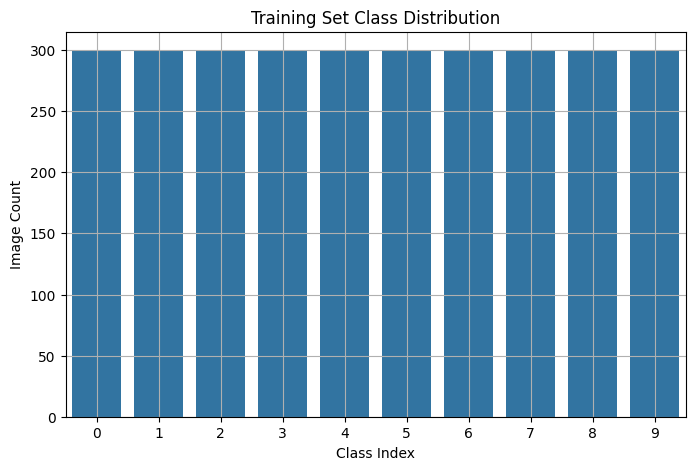

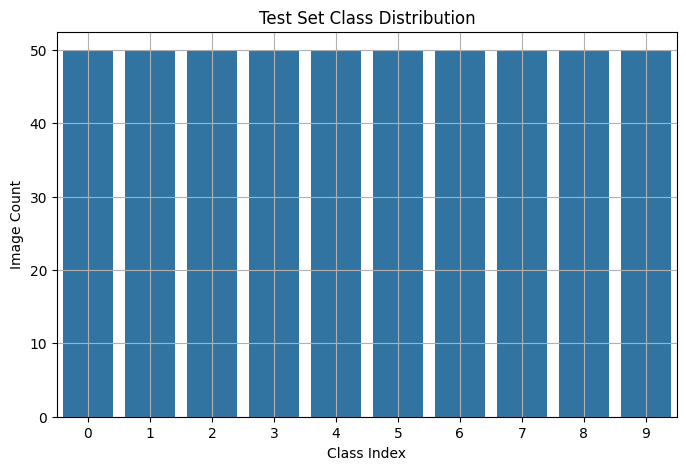

In [ ]:
# Function to plot class distribution
def plot_class_distribution(y_data, title):
    y_int = np.argmax(y_data, axis=1)
    plt.figure(figsize=(8, 5))
    sns.countplot(x=y_int)
    plt.title(title)
    plt.xlabel("Class Index")
    plt.ylabel("Image Count")
    plt.grid(True)
    plt.show()

# Plotting class distributions for training and test sets
plot_class_distribution(y_train_final, "Training Set Class Distribution")
plot_class_distribution(y_test_final, "Test Set Class Distribution")


### Verify the data

To verify that the dataset looks correct, let's plot the first 25 images from the training set and display the class name below each image:


### Create the convolutional base

The 6 lines of code below define the convolutional base using a common pattern: a stack of [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) and [MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) layers.

As input, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size. If you are new to these dimensions, color_channels refers to (R,G,B). In this example, you will configure your CNN to process inputs of shape (32, 32, 3), which is the format of CIFAR images. You can do this by passing the argument `input_shape` to your first layer.


In [87]:
# TASK-2 : Building Basic CNN Model consisting of several Convolutional and Max Pooling Layers
def build_base_model():
    model = models.Sequential([
        layers.Input(shape=(32, 32, 3)),

        # Block 1
        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),


        # Block 2
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),


        # Dense
        layers.Flatten(),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.25),


        # Change the number of units in the final Dense layer to 10
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

base_model = build_base_model()
base_model.summary()

Model: "sequential_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_111 (Conv2D)             │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_108               │ (None, 16, 16, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_112 (Conv2D)             │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_109               │ (None, 8, 8, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_42 (Flatten)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_112 (Dense)               │ (None, 32)             │       131,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_113 (Dense)               │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_114 (Dense)               │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 153,258 (598.66 KB)

 Trainable params: 153,258 (598.66 KB)

 Non-trainable params: 0 (0.00 B)

Let's display the architecture of your model so far:

In [90]:
# TASK-3 : Train and Evaluate the Base Model 20 Epochs
history = base_model.fit(
    x_train_final, y_train_final,
    epochs=20,
    batch_size=64,
    validation_data=(x_test_final, y_test_final)
)

Epoch 1/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6675 - loss: 0.9462 - val_accuracy: 0.6360 - val_loss: 1.1615
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6478 - loss: 0.9758 - val_accuracy: 0.6500 - val_loss: 1.1278
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6772 - loss: 0.9330 - val_accuracy: 0.6240 - val_loss: 1.1691
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6745 - loss: 0.9067 - val_accuracy: 0.6440 - val_loss: 1.1184
Epoch 5/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6997 - loss: 0.8791 - val_accuracy: 0.6220 - val_loss: 1.1532
Epoch 6/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6850 - loss: 0.8706 - val_accuracy: 0.6300 - val_loss: 1.1312
Epoch 7/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7081 - loss: 0.8183 - val_accuracy: 0.6340 - val_loss: 1.1863
Epoch 8/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7250 - loss: 0.7767 - val_accuracy: 0.6320 - val_loss:

In [91]:
# TASK-4 : Evaluation
test_loss, test_acc = base_model.evaluate(x_test_final, y_test_final)
print(f"Test Accuracy for 20 epochs: {test_acc * 100:.2f}%")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6875 - loss: 1.1725 
Test Accuracy for 20 epochs: 65.20%


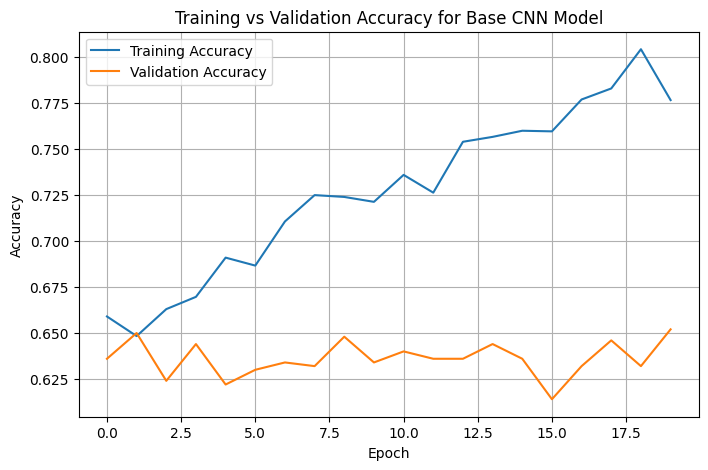

In [92]:
# Plot training and validation accuracy for 20 Epochs
def plot_accuracy(history):
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training vs Validation Accuracy for Base CNN Model')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_accuracy(history)

Above, you can see that the output of every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels). The width and height dimensions tend to shrink as you go deeper in the network. The number of output channels for each Conv2D layer is controlled by the first argument (e.g., 32 or 64). Typically,  as the width and height shrink, you can afford (computationally) to add more output channels in each Conv2D layer.

### Add Dense layers on top

To complete the model, you will feed the last output tensor from the convolutional base (of shape (4, 4, 64)) into one or more Dense layers to perform classification. Dense layers take vectors as input (which are 1D), while the current output is a 3D tensor. First, you will flatten (or unroll) the 3D output to 1D,  then add one or more Dense layers on top. CIFAR has 10 output classes, so you use a final Dense layer with 10 outputs.

In [101]:
# TASK-5 : For improving Accuracy
# TASK-5.1 : Increasing size and depth of inner layers (Changing the shape from 32 to 64 and 128 for two separate blocks)
def build_deeper_model():
    model = models.Sequential([
        layers.Input(shape=(32, 32, 3)),
        # Block 1
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.2),

        # Block 2
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),

        # Dense
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Build and summarize the model with increased filters
deeper_model_increased = build_deeper_model()
deeper_model_increased.summary()


Model: "sequential_46"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_123 (Conv2D)             │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_117               │ (None, 16, 16, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_124 (Conv2D)             │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_118               │ (None, 8, 8, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_46 (Flatten)            │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_124 (Dense)               │ (None, 64)             │       524,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_125 (Dense)               │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_126 (Dense)               │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 610,378 (2.33 MB)

 Trainable params: 609,994 (2.33 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step - accuracy: 0.2488 - loss: 2.3377 - val_accuracy: 0.1960 - val_loss: 2.4497
Epoch 2/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4689 - loss: 1.5892 - val_accuracy: 0.1100 - val_loss: 4.0833
Epoch 3/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5771 - loss: 1.3102 - val_accuracy: 0.1120 - val_loss: 6.0928
Epoch 4/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6710 - loss: 1.0538 - val_accuracy: 0.1220 - val_loss: 6.9094
Epoch 5/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7356 - loss: 0.8573 - val_accuracy: 0.1620 - val_loss: 7.9141
Epoch 6/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7717 - loss: 0.7295 - val_accuracy: 0.1360 - val_loss: 7.3981
Epoch 7/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8283 - loss: 0.5859 - val_accuracy: 0.2280 - val_loss: 5.5164
Epoch 8/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8608 - loss: 0.4716 - val_accuracy: 0.2160 - val_loss

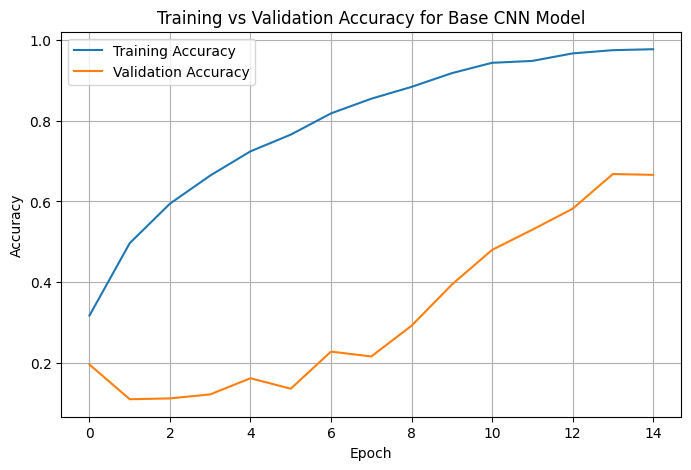

In [106]:
#Train and Evaluate the Deeper Model (Increase Size and Depth)
deeper_model = build_deeper_model()
history = deeper_model.fit(
    x_train_final, y_train_final,
    epochs=15,
    batch_size=64,
    validation_data=(x_test_final, y_test_final)
)

# Evaluation
test_loss, test_acc = deeper_model.evaluate(x_test_final, y_test_final)
print(f"Test Accuracy_Deeper Model(Increasing Size and Depth): {test_acc * 100:.2f}%")
plot_accuracy(history)

In [107]:
#Train and Evaluate the Deeper Model for TASK-5.1 for 25 Epochs
history = deeper_model.fit(
    x_train_final, y_train_final,
    epochs=25,
    batch_size=64,
    validation_data=(x_test_final, y_test_final)
)

# Evaluation
test_loss, test_acc = deeper_model.evaluate(x_test_final, y_test_final)
print(f"Test Accuracy_Deeper Model(Increasing Size and Depth for 30 epochs): {test_acc * 100:.2f}%")


Epoch 1/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9697 - loss: 0.1439 - val_accuracy: 0.6680 - val_loss: 1.6683
Epoch 2/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9724 - loss: 0.1440 - val_accuracy: 0.5600 - val_loss: 2.8115
Epoch 3/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9641 - loss: 0.1525 - val_accuracy: 0.6760 - val_loss: 1.6455
Epoch 4/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9794 - loss: 0.1139 - val_accuracy: 0.6700 - val_loss: 1.7544
Epoch 5/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9655 - loss: 0.1480 - val_accuracy: 0.6540 - val_loss: 2.0857
Epoch 6/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9828 - loss: 0.0994 - val_accuracy: 0.6440 - val_loss: 1.7873
Epoch 7/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9827 - loss: 0.1084 - val_accuracy: 0.6440 - val_loss: 1.9791
Epoch 8/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9808 - loss: 0.1065 - val_accuracy: 0.6200 - val_loss

In [25]:
# TASK-5.2 : Convolutional/Maxpooling (More Layers)
def build_very_deep_model():
    model = models.Sequential([
        # Block 1
        layers.Input(shape=(32, 32, 3)),
        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.20),

        # Block 2
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.20),

        # Block 3
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout (0.25),


        # Block 4
        layers.Conv2D(256, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout (0.25),

        # Dense
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model
build_very_deep_model = build_very_deep_model()
build_very_deep_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 520,906 (1.99 MB)

 Trainable params: 520,906 (1.99 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
#Train and Evaluate very deeper Model (Convolutional/Max Pooling)  for TASK-5.2
history = build_very_deep_model.fit(
    x_train_final, y_train_final,
    epochs=20,
    batch_size=64,
    validation_data=(x_test_final, y_test_final)
)

# Evaluation
test_loss, test_acc = build_very_deep_model.evaluate(x_test_final, y_test_final)
print(f"Test Accuracy_build_very_deep_model (Convolutional/Maxpooling) : {test_acc * 100:.2f}%")


Epoch 1/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.1076 - loss: 2.2871 - val_accuracy: 0.2280 - val_loss: 2.1336
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2317 - loss: 2.0965 - val_accuracy: 0.3520 - val_loss: 1.9015
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3247 - loss: 1.8899 - val_accuracy: 0.3940 - val_loss: 1.6802
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4270 - loss: 1.6356 - val_accuracy: 0.4560 - val_loss: 1.5776
Epoch 5/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4929 - loss: 1.5007 - val_accuracy: 0.5520 - val_loss: 1.3837
Epoch 6/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5216 - loss: 1.4048 - val_accuracy: 0.5660 - val_loss: 1.2964
Epoch 7/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5456 - loss: 1.3031 - val_accuracy: 0.5660 - val_loss: 1.2637
Epoch 8/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5858 - loss: 1.1972 - val_accuracy: 0.6020 - val_los

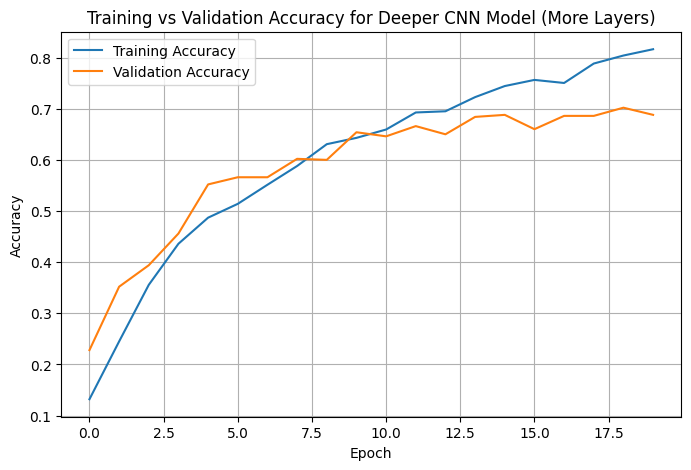

In [26]:
# Plot training and validation accuracy for the deeper model (Task 5.2)
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy for Deeper CNN Model (More Layers)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [56]:
#Train and Evaluate the Deeper Model for TASK-5.2 for 30 epochs
history = build_very_deep_model.fit(
    x_train_final, y_train_final,
    epochs=30,
    batch_size=64,
    validation_data=(x_test_final, y_test_final)
)

# Evaluation
test_loss, test_acc = build_very_deep_model.evaluate(x_test_final, y_test_final)
print(f"Test Accuracy_build_very_deep_model (Convolutional/Maxpooling) for 30 epochs: {test_acc * 100:.2f}%")



Epoch 1/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - accuracy: 0.1107 - loss: 2.3100 - val_accuracy: 0.2240 - val_loss: 2.1770
Epoch 2/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1990 - loss: 2.1569 - val_accuracy: 0.3580 - val_loss: 1.8586
Epoch 3/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3144 - loss: 1.8956 - val_accuracy: 0.4000 - val_loss: 1.6486
Epoch 4/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4043 - loss: 1.7001 - val_accuracy: 0.4540 - val_loss: 1.5105
Epoch 5/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4801 - loss: 1.4905 - val_accuracy: 0.5060 - val_loss: 1.4148
Epoch 6/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5405 - loss: 1.3490 - val_accuracy: 0.5760 - val_loss: 1.2862
Epoch 7/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5828 - loss: 1.2113 - val_accuracy: 0.5800 - val_loss: 1.2096
Epoch 8/30
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5965 - loss: 1.1613 - val_accuracy: 0.6340 - val_los

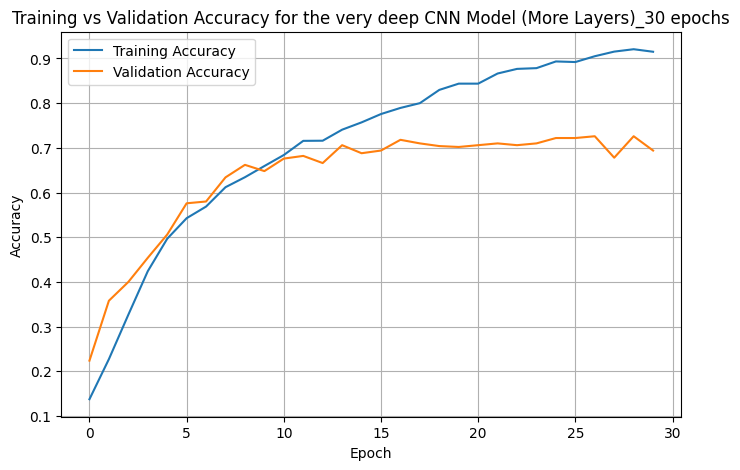

In [57]:
# Plot training and validation accuracy for the deeper model for 30 epochs
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy for the very deep CNN Model (More Layers)_30 epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
# TASK-5.3 : Experiment with Activation Functions
# --------- ReLU Model ---------
def build_model_leakyrelu():
    model = models.Sequential([
        layers.Input(shape=(32, 32, 3)),

        layers.Conv2D(32, (3,3), padding='same'),
        layers.LeakyReLU(alpha=0.1),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3,3), padding='same'),
        layers.LeakyReLU(alpha=0.1),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),

        layers.Conv2D(128, (3,3), padding='same'),
        layers.LeakyReLU(alpha=0.1),
        layers.MaxPooling2D((2,2)),

        layers.Flatten(),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# --------- Sigmoid Model ---------
def build_model_sigmoid():
    model = models.Sequential([
        layers.Input(shape=(32, 32, 3)),

        layers.Conv2D(32, (3,3), padding='same'),
        layers.Activation('sigmoid'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3,3), padding='same'),
        layers.Activation('sigmoid'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),

        layers.Conv2D(128, (3,3), padding='same'),
        layers.Activation('sigmoid'),
        layers.MaxPooling2D((2,2)),

        layers.Flatten(),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# --------- Tanh Model ---------
def build_model_tanh():
    model = models.Sequential([
        layers.Input(shape=(32, 32, 3)),

        layers.Conv2D(32, (3,3), padding='same'),
        layers.Activation('tanh'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3,3), padding='same'),
        layers.Activation('tanh'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),

        layers.Conv2D(128, (3,3), padding='same'),
        layers.Activation('tanh'),
        layers.MaxPooling2D((2,2)),

        layers.Flatten(),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

  # --------- Swish Model ---------
def build_model_swish():
    model = models.Sequential([
        layers.Input(shape=(32, 32, 3)),

        layers.Conv2D(32, (3,3), padding='same'),
        layers.Activation(swish),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3,3), padding='same'),
        layers.Activation(swish),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),

        layers.Conv2D(128, (3,3), padding='same'),
        layers.Activation(swish),
        layers.MaxPooling2D((2,2)),

        layers.Flatten(),
        layers.Dense(32, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [29]:
# Build each model
model_leakyrelu = build_model_leakyrelu()
model_sigmoid = build_model_sigmoid()
model_tanh = build_model_tanh()
model_swish = build_model_swish()

# Print model summaries
print("\nLeaky ReLU Model Summary:")
model_leakyrelu.summary()

print("\nSigmoid Model Summary:")
model_sigmoid.summary()

print("\nTanh Model Summary:")
model_tanh.summary()

print("\nSwish Model Summary:")
model_swish.summary()


Leaky ReLU Model Summary:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 10)             │        20,490 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 113,738 (444.29 KB)

 Trainable params: 113,738 (444.29 KB)

 Non-trainable params: 0 (0.00 B)


Sigmoid Model Summary:


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 10)             │        20,490 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 113,738 (444.29 KB)

 Trainable params: 113,738 (444.29 KB)

 Non-trainable params: 0 (0.00 B)


Tanh Model Summary:


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 10)             │        20,490 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 113,738 (444.29 KB)

 Trainable params: 113,738 (444.29 KB)

 Non-trainable params: 0 (0.00 B)


Swish Model Summary:


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_27 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 32)             │        65,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 170,538 (666.16 KB)

 Trainable params: 170,538 (666.16 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
#Train and Evaluate each model
epochs = 20
batch_size = 64 # Using 64 batch size as in your original code snippet

# Train each model
print("\nTraining Leaky ReLU model...")
history_leakyrelu = model_leakyrelu.fit(
    x_train_final, y_train_final,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_test_final, y_test_final),
    verbose=2
)

print("\nTraining Sigmoid model...")
history_sigmoid = model_sigmoid.fit(
    x_train_final, y_train_final,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_test_final, y_test_final),
    verbose=2
)

print("\nTraining Tanh model...")
history_tanh = model_tanh.fit(
    x_train_final, y_train_final,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_test_final, y_test_final),
    verbose=2
)

print("\nTraining Swish model...")
history_swish = model_swish.fit(
    x_train_final, y_train_final,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_test_final, y_test_final),
    verbose=2
)


Training Leaky ReLU model...
Epoch 1/20
47/47 - 7s - 153ms/step - accuracy: 0.1967 - loss: 2.1876 - val_accuracy: 0.2940 - val_loss: 1.9728
Epoch 2/20
47/47 - 5s - 98ms/step - accuracy: 0.3310 - loss: 1.8923 - val_accuracy: 0.4280 - val_loss: 1.6902
Epoch 3/20
47/47 - 0s - 6ms/step - accuracy: 0.4207 - loss: 1.6760 - val_accuracy: 0.4900 - val_loss: 1.5501
Epoch 4/20
47/47 - 0s - 7ms/step - accuracy: 0.4857 - loss: 1.5233 - val_accuracy: 0.5500 - val_loss: 1.3905
Epoch 5/20
47/47 - 0s - 6ms/step - accuracy: 0.5297 - loss: 1.3852 - val_accuracy: 0.5720 - val_loss: 1.3529
Epoch 6/20
47/47 - 0s - 6ms/step - accuracy: 0.5737 - loss: 1.2735 - val_accuracy: 0.5920 - val_loss: 1.2258
Epoch 7/20
47/47 - 0s - 6ms/step - accuracy: 0.6043 - loss: 1.1811 - val_accuracy: 0.6040 - val_loss: 1.1991
Epoch 8/20
47/47 - 0s - 6ms/step - accuracy: 0.6287 - loss: 1.1142 - val_accuracy: 0.6240 - val_loss: 1.1231
Epoch 9/20
47/47 - 0s - 6ms/step - accuracy: 0.6517 - loss: 1.0329 - val_accuracy: 0.6220 - val


Evaluating models on Initial Subset (Classes 0-9)...
Leaky ReLU Test Accuracy (Initial Subset): 0.6720
Sigmoid Test Accuracy (Initial Subset): 0.4060
Tanh Test Accuracy (Initial Subset): 0.6820
Swish Test Accuracy (Initial Subset): 0.6520


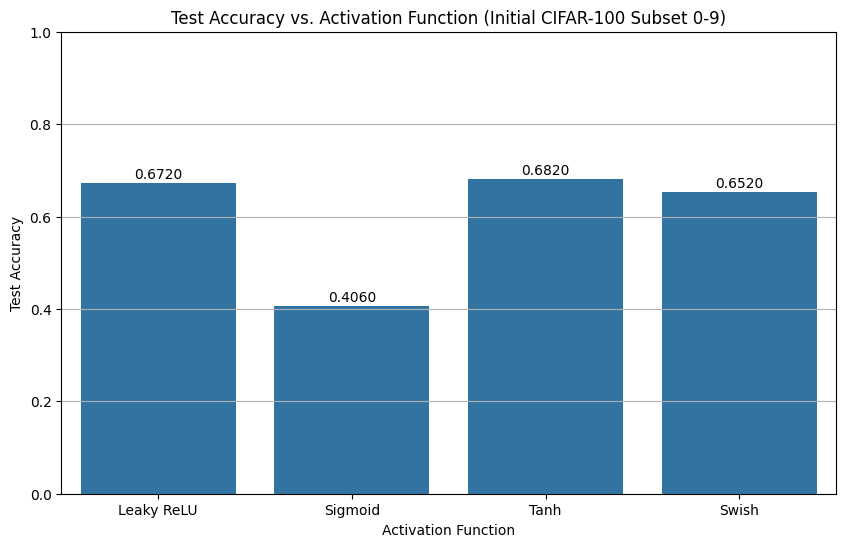

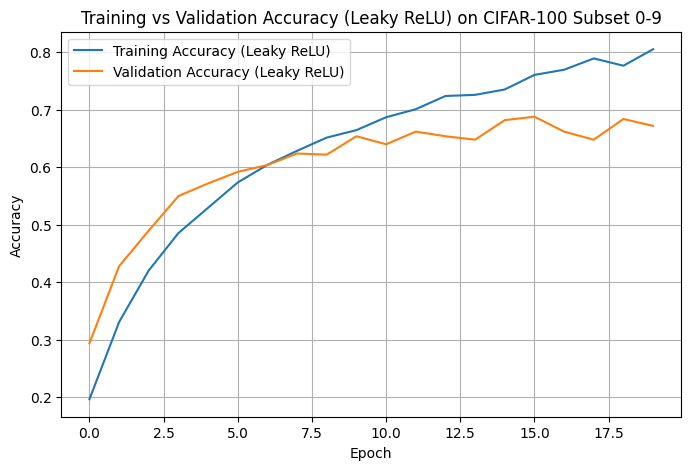

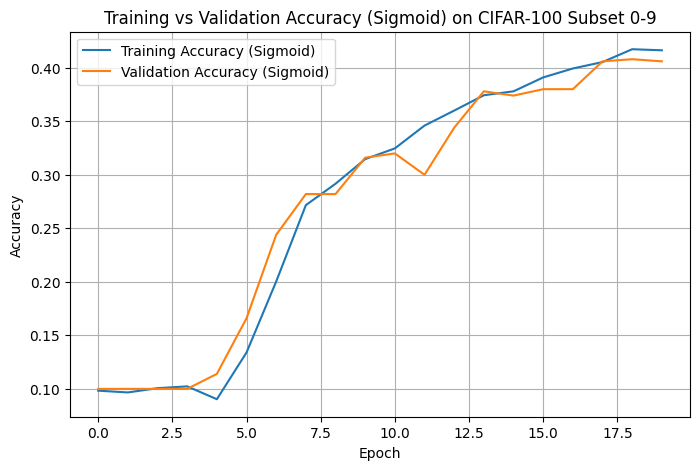

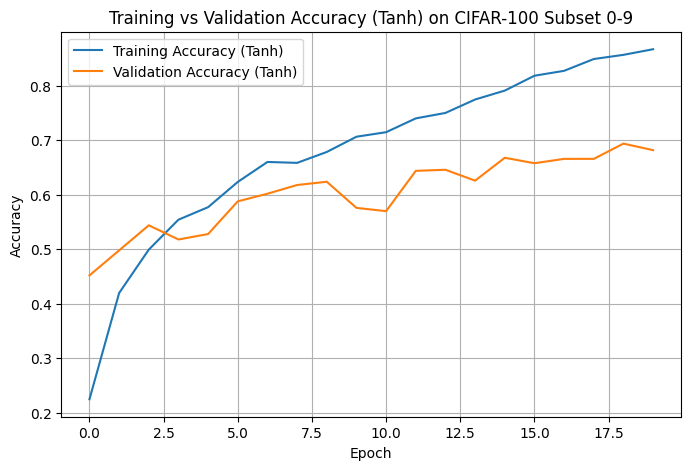

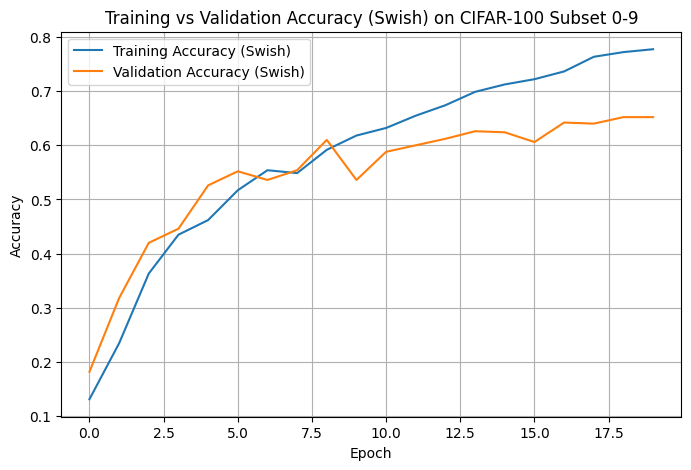

In [32]:
# --- TASK-5.3: Experiment with Activation Functions (Evaluation and Plotting - Initial Subset 0-9) ---
# Evaluate each model on the initial subset test data
print("\nEvaluating models on Initial Subset (Classes 0-9)...")
test_loss_leakyrelu_initial, test_acc_leakyrelu_initial = model_leakyrelu.evaluate(x_test_final, y_test_final, verbose=0)
print(f"Leaky ReLU Test Accuracy (Initial Subset): {test_acc_leakyrelu_initial:.4f}")

test_loss_sigmoid_initial, test_acc_sigmoid_initial = model_sigmoid.evaluate(x_test_final, y_test_final, verbose=0)
print(f"Sigmoid Test Accuracy (Initial Subset): {test_acc_sigmoid_initial:.4f}")

test_loss_tanh_initial, test_acc_tanh_initial = model_tanh.evaluate(x_test_final, y_test_final, verbose=0)
print(f"Tanh Test Accuracy (Initial Subset): {test_acc_tanh_initial:.4f}")

test_loss_swish_initial, test_acc_swish_initial = model_swish.evaluate(x_test_final, y_test_final, verbose=0)
print(f"Swish Test Accuracy (Initial Subset): {test_acc_swish_initial:.4f}")

# Store the test accuracies for the initial subset
activations_initial = ['Leaky ReLU', 'Sigmoid', 'Tanh', 'Swish']
accuracies_initial = [
    test_acc_leakyrelu_initial,
    test_acc_sigmoid_initial,
    test_acc_tanh_initial,
    test_acc_swish_initial
]

plt.figure(figsize=(10, 6))
sns.barplot(x=activations_initial, y=accuracies_initial)
plt.title('Test Accuracy vs. Activation Function (Initial CIFAR-100 Subset 0-9)')
plt.xlabel('Activation Function')
plt.ylabel('Test Accuracy')
plt.ylim(0, 1) # Accuracy is between 0 and 1
plt.grid(axis='y')

# Add accuracy values on top of bars
for i, acc in enumerate(accuracies_initial):
    plt.text(i, acc + 0.01, f'{acc:.4f}', ha='center')

plt.show()

# --- Plotting Accuracy for Each Activation Function (0-9 Subset) ---

# Plot for Leaky ReLU
plt.figure(figsize=(8, 5))
plt.plot(history_leakyrelu.history['accuracy'], label='Training Accuracy (Leaky ReLU)')
plt.plot(history_leakyrelu.history['val_accuracy'], label='Validation Accuracy (Leaky ReLU)')
plt.title('Training vs Validation Accuracy (Leaky ReLU) on CIFAR-100 Subset 0-9')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot for Sigmoid
plt.figure(figsize=(8, 5))
plt.plot(history_sigmoid.history['accuracy'], label='Training Accuracy (Sigmoid)')
plt.plot(history_sigmoid.history['val_accuracy'], label='Validation Accuracy (Sigmoid)')
plt.title('Training vs Validation Accuracy (Sigmoid) on CIFAR-100 Subset 0-9')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot for Tanh
plt.figure(figsize=(8, 5))
plt.plot(history_tanh.history['accuracy'], label='Training Accuracy (Tanh)')
plt.plot(history_tanh.history['val_accuracy'], label='Validation Accuracy (Tanh)')
plt.title('Training vs Validation Accuracy (Tanh) on CIFAR-100 Subset 0-9')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot for Swish
plt.figure(figsize=(8, 5))
plt.plot(history_swish.history['accuracy'], label='Training Accuracy (Swish)')
plt.plot(history_swish.history['val_accuracy'], label='Validation Accuracy (Swish)')
plt.title('Training vs Validation Accuracy (Swish) on CIFAR-100 Subset 0-9')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

**Task 5.4 Effect of Activation Functions and Their Interaction with Network Depth and Size**
Different activation functions matter a lot for model performance. Your experiments gave me the following results:
•	Tanh came out on top, giving 68.80% accuracy (initial subset), truly showing its prowess in non-linear transformations.
•	Leaky ReLU managed to do very well as well, scoring up to 67.00% (initial) and 66.20% (new subset).
•	Swish had erratic behaviour, 62.20% moderate under initial and 63.80% under new subset.
•	Sigmoid really lagged behind, giving scores of only around 39–43%, probably due to the vanishing gradient problem in deeper nets.
When activation function choice was combined with network sizes and depths, the results revealed that activations like Tanh and Leaky ReLU better scale with deep networks. For example, in very deep architectures, Tanh and Leaky ReLU kept high accuracies while Sigmoid could not benefit from the additional depth due to saturation of gradients.
Thus, the effectiveness of an activation function is not just an inherent property of its own, but one that is, to some extent, dictated by the chosen network architecture. In this sense, pairing activation functions like Tanh or Leaky ReLU with deeper networks that are well regularized yielded stronger performance gains.


In [33]:
# TASK-5.5: Experiment with Optimizers and Learning Rates
def build_base_model():
    model = models.Sequential([
        layers.Input(shape=(32, 32, 3)),
        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),

        layers.Flatten(),
        layers.Dense(32, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')  # Adjust if you used different class count
    ])
    return model

# Build an instance of the base model to display its summary
base_model_for_summary = build_base_model()

print("\nBase Model Summary for Optimizer Experiment:")
base_model_for_summary.summary()




Base Model Summary for Optimizer Experiment:


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 32)             │       131,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 153,258 (598.66 KB)

 Trainable params: 153,258 (598.66 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.1173 - loss: 2.3015 - val_accuracy: 0.1540 - val_loss: 2.2332
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1806 - loss: 2.2130 - val_accuracy: 0.3520 - val_loss: 1.8956
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3476 - loss: 1.8849 - val_accuracy: 0.3720 - val_loss: 1.7233
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4164 - loss: 1.7131 - val_accuracy: 0.4860 - val_loss: 1.5157
Epoch 5/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4801 - loss: 1.5358 - val_accuracy: 0.4800 - val_loss: 1.4644
Epoch 6/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5082 - loss: 1.4366 - val_accuracy: 0.5420 - val_loss: 1.3753
Epoch 7/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5345 - loss: 1.3360 - val_accuracy: 0.6040 - val_loss: 1.2514
Epoch 8/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5793 - loss: 1.2397 - val_accuracy: 0.5720 - val_loss

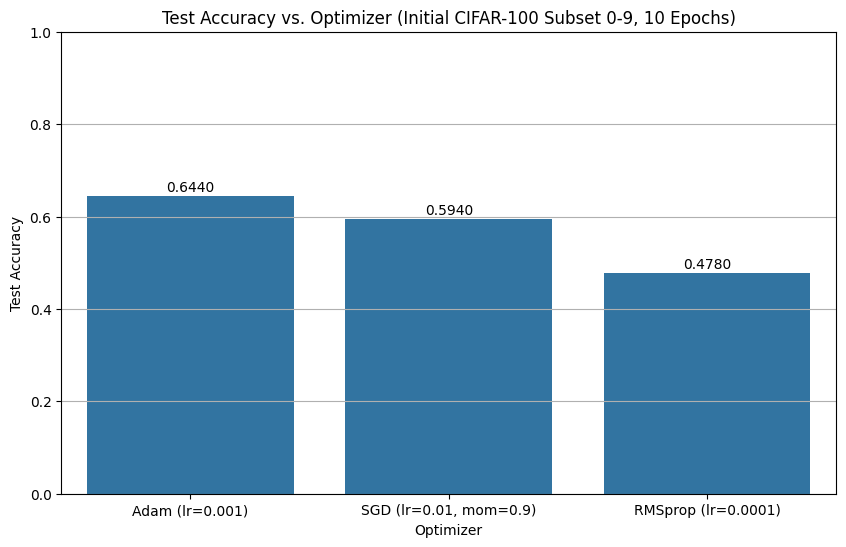

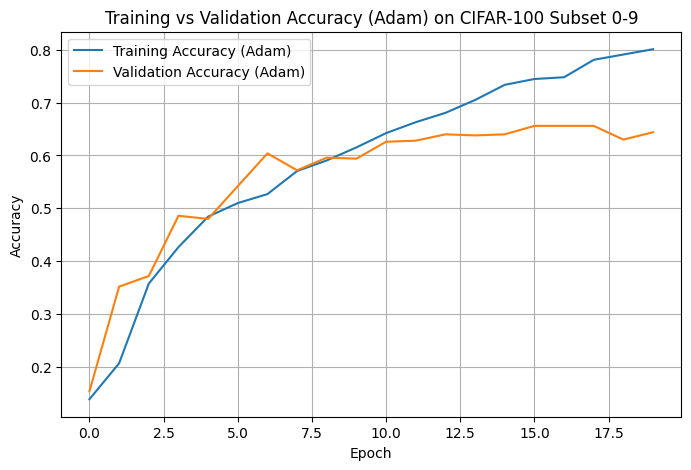

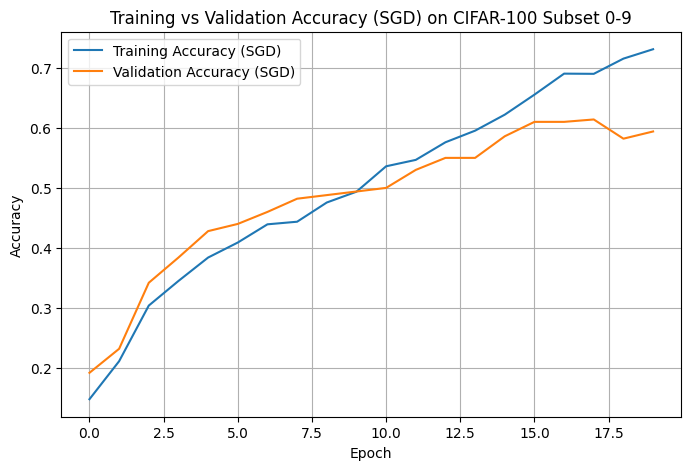

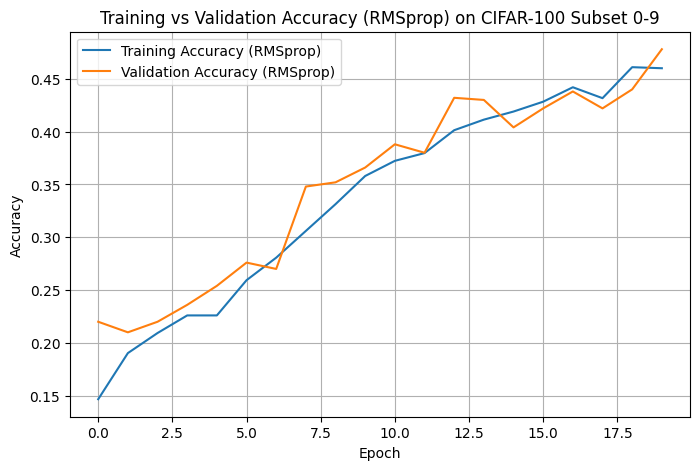

In [34]:
# Exp 1: Adam with learning rate 0.001 (Epochs-20)
model_adam, history_adam = build_base_model(), None
opt_adam = Adam(learning_rate=0.001)
model_adam.compile(optimizer=opt_adam, loss='categorical_crossentropy', metrics=['accuracy'])
history_adam = model_adam.fit(x_train_final, y_train_final, epochs=20, batch_size=64,
                              validation_data=(x_test_final, y_test_final))

# Exp 2: SGD with learning rate 0.01 (Epochs-20)
model_sgd, history_sgd = build_base_model(), None
opt_sgd = SGD(learning_rate=0.01, momentum=0.9)
model_sgd.compile(optimizer=opt_sgd, loss='categorical_crossentropy', metrics=['accuracy'])
history_sgd = model_sgd.fit(x_train_final, y_train_final, epochs=20, batch_size=64,
                            validation_data=(x_test_final, y_test_final))

# Exp 3: RMSprop with learning rate 0.0001 (Epochs-20)
model_rmsprop, history_rmsprop = build_base_model(), None
opt_rmsprop = RMSprop(learning_rate=0.0001)
model_rmsprop.compile(optimizer=opt_rmsprop, loss='categorical_crossentropy', metrics=['accuracy'])
history_rmsprop = model_rmsprop.fit(x_train_final, y_train_final, epochs=20, batch_size=64,
                                    validation_data=(x_test_final, y_test_final))

print("Adam final val accuracy:", history_adam.history['val_accuracy'][-1])
print("SGD final val accuracy:", history_sgd.history['val_accuracy'][-1])
print("RMSprop final val accuracy:", history_rmsprop.history['val_accuracy'][-1])

# Getting the final validation accuracy for each optimizer
adam_acc = history_adam.history['val_accuracy'][-1]
sgd_acc = history_sgd.history['val_accuracy'][-1]
rmsprop_acc = history_rmsprop.history['val_accuracy'][-1]

# Storing the optimizer names and their accuracies
optimizers = ['Adam (lr=0.001)', 'SGD (lr=0.01, mom=0.9)', 'RMSprop (lr=0.0001)']
accuracies = [adam_acc, sgd_acc, rmsprop_acc]

plt.figure(figsize=(10, 6))
sns.barplot(x=optimizers, y=accuracies)
plt.title('Test Accuracy vs. Optimizer (Initial CIFAR-100 Subset 0-9, 10 Epochs)')
plt.xlabel('Optimizer')
plt.ylabel('Test Accuracy')
plt.ylim(0, 1)
plt.grid(axis='y')

# Add accuracy values on top of bars
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f'{acc:.4f}', ha='center')

plt.show()

# --- Plotting Accuracy for Each Optimizer (0-9 Subset) ---

# Plot for Adam
plt.figure(figsize=(8, 5))
plt.plot(history_adam.history['accuracy'], label='Training Accuracy (Adam)')
plt.plot(history_adam.history['val_accuracy'], label='Validation Accuracy (Adam)')
plt.title('Training vs Validation Accuracy (Adam) on CIFAR-100 Subset 0-9')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot for SGD
plt.figure(figsize=(8, 5))
plt.plot(history_sgd.history['accuracy'], label='Training Accuracy (SGD)')
plt.plot(history_sgd.history['val_accuracy'], label='Validation Accuracy (SGD)')
plt.title('Training vs Validation Accuracy (SGD) on CIFAR-100 Subset 0-9')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot for RMSprop
plt.figure(figsize=(8, 5))
plt.plot(history_rmsprop.history['accuracy'], label='Training Accuracy (RMSprop)')
plt.plot(history_rmsprop.history['val_accuracy'], label='Validation Accuracy (RMSprop)')
plt.title('Training vs Validation Accuracy (RMSprop) on CIFAR-100 Subset 0-9')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [35]:
# TASK-5.6: Experiment with Various Batch Sizes and Epochs (Size : 32,64,128) and ( Epochs :10,15,20)

def build_base_model():
    model = models.Sequential([
        layers.Input(shape=(32, 32, 3)),
        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    return model

# Build an instance of the base model to display its summary
base_model_for_summary = build_base_model()

print("\nBase Model Summary for Batch Size and Epochs Experiment:")
base_model_for_summary.summary()


Base Model Summary for Batch Size and Epochs Experiment:


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_38 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_15 (Flatten)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 233,994 (914.04 KB)

 Trainable params: 233,994 (914.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.1352 - loss: 2.2539 - val_accuracy: 0.2960 - val_loss: 1.9178
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2936 - loss: 1.9303 - val_accuracy: 0.4000 - val_loss: 1.6461
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4282 - loss: 1.6350 - val_accuracy: 0.4960 - val_loss: 1.4612
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5294 - loss: 1.3991 - val_accuracy: 0.4980 - val_loss: 1.3934
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5898 - loss: 1.2118 - val_accuracy: 0.5720 - val_loss: 1.2433
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6152 - loss: 1.1024 - val_accuracy: 0.6060 - val_loss: 1.1381
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6618 - loss: 0.9969 - val_accuracy: 0.6100 - val_loss: 1.1494
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6909 - loss: 0.9329 - val_accuracy: 0.6520 - val_loss

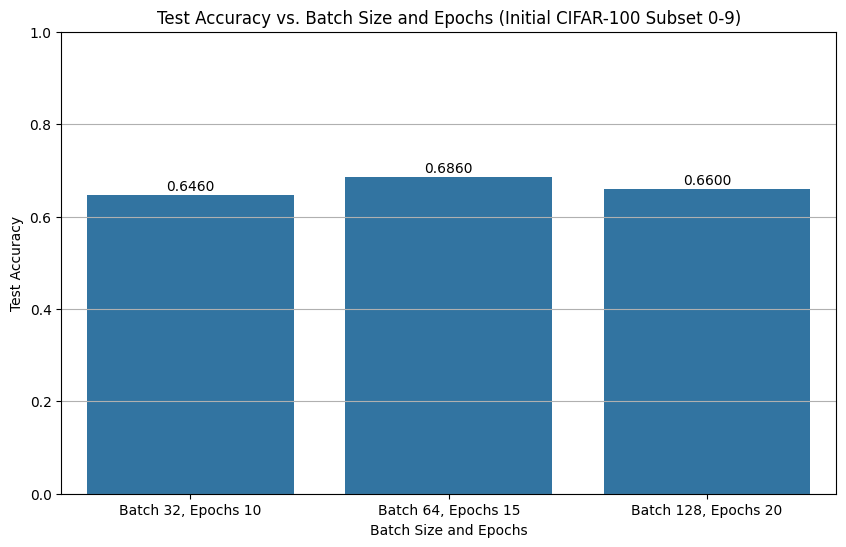

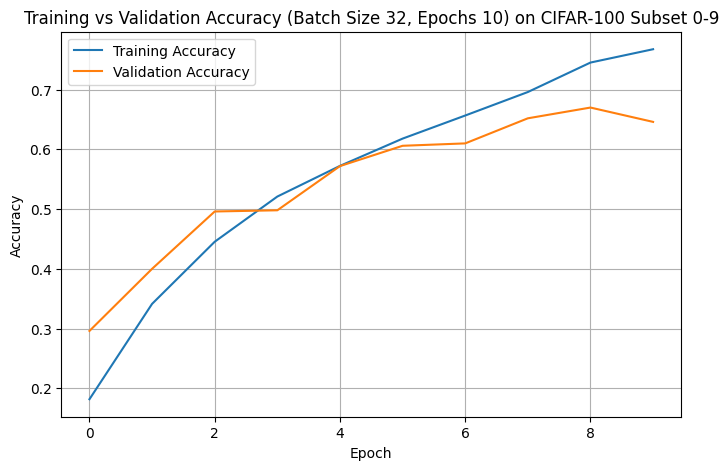

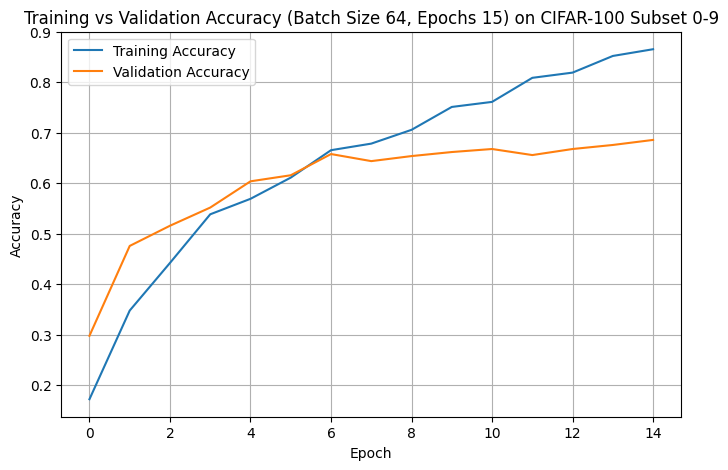

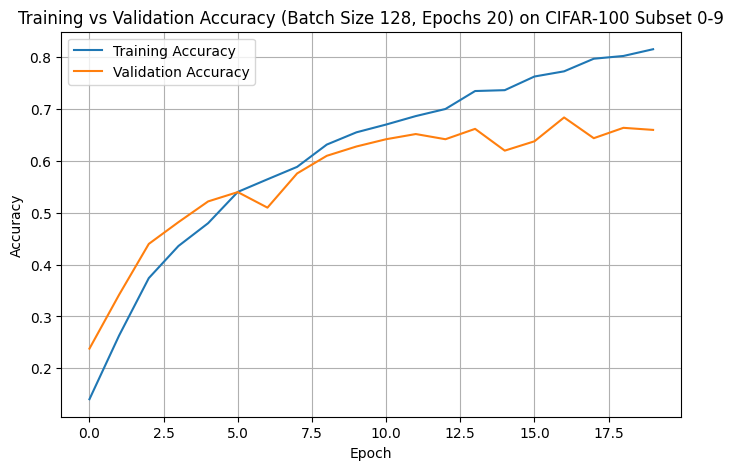

In [36]:
# Exp 1: Batch size 32, Epochs 10
model_b32_e10 = build_base_model()
model_b32_e10.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_b32_e10 = model_b32_e10.fit(x_train_final, y_train_final, epochs=10, batch_size=32,
                                    validation_data=(x_test_final, y_test_final))

# Exp 2: Batch size 64, Epochs 15
model_b64_e15 = build_base_model()
model_b64_e15.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_b64_e15 = model_b64_e15.fit(x_train_final, y_train_final, epochs=15, batch_size=64,
                                    validation_data=(x_test_final, y_test_final))

# Exp 3: Batch size 128, Epochs 20
model_b128_e20 = build_base_model()
model_b128_e20.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_b128_e20 = model_b128_e20.fit(x_train_final, y_train_final, epochs=20, batch_size=128,
                                      validation_data=(x_test_final, y_test_final))

print("Batch 32, Epoch 10 - Val Accuracy:", history_b32_e10.history['val_accuracy'][-1])
print("Batch 64, Epoch 15 - Val Accuracy:", history_b64_e15.history['val_accuracy'][-1])
print("Batch 128, Epoch 20 - Val Accuracy:", history_b128_e20.history['val_accuracy'][-1])

# Get the final validation accuracy for each combination
acc_b32_e10 = history_b32_e10.history['val_accuracy'][-1]
acc_b64_e15 = history_b64_e15.history['val_accuracy'][-1]
acc_b128_e20 = history_b128_e20.history['val_accuracy'][-1]

# Store the combinations and their accuracies
combinations = ['Batch 32, Epochs 10', 'Batch 64, Epochs 15', 'Batch 128, Epochs 20']
accuracies = [acc_b32_e10, acc_b64_e15, acc_b128_e20]

plt.figure(figsize=(10, 6))
sns.barplot(x=combinations, y=accuracies)
plt.title('Test Accuracy vs. Batch Size and Epochs (Initial CIFAR-100 Subset 0-9)')
plt.xlabel('Batch Size and Epochs')
plt.ylabel('Test Accuracy')
plt.ylim(0, 1) # Accuracy is between 0 and 1
plt.grid(axis='y')

# Add accuracy values on top of bars
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f'{acc:.4f}', ha='center')

plt.show()

# --- Plotting Accuracy for Each Batch Size/Epoch Combination (0-9 Subset) ---

# Plot for Batch Size 32, Epochs 10
plt.figure(figsize=(8, 5))
plt.plot(history_b32_e10.history['accuracy'], label='Training Accuracy')
plt.plot(history_b32_e10.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy (Batch Size 32, Epochs 10) on CIFAR-100 Subset 0-9')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot for Batch Size 64, Epochs 15
plt.figure(figsize=(8, 5))
plt.plot(history_b64_e15.history['accuracy'], label='Training Accuracy')
plt.plot(history_b64_e15.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy (Batch Size 64, Epochs 15) on CIFAR-100 Subset 0-9')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot for Batch Size 128, Epochs 20
plt.figure(figsize=(8, 5))
plt.plot(history_b128_e20.history['accuracy'], label='Training Accuracy')
plt.plot(history_b128_e20.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy (Batch Size 128, Epochs 20) on CIFAR-100 Subset 0-9')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


Here's the complete architecture of your model:

The network summary shows that (4, 4, 64) outputs were flattened into vectors of shape (1024) before going through two Dense layers.

### Compile and train the model

In [125]:
#TASK-6
# Repeat Step 5: Use a different subset of CIFAR-100 (classes 20–29)

# Step 1: Load and filter new 10 classes from CIFAR-100
new_selected_classes = [20, 21, 22, 23, 24, 25, 26, 27, 28, 29]

# Now use the corrected variable name
train_mask_new = np.isin(y_train, new_selected_classes).flatten()
test_mask_new = np.isin(y_test, new_selected_classes).flatten()

x_train_new = x_train[train_mask_new]
y_train_new = y_train[train_mask_new]
x_test_new = x_test[test_mask_new]
y_test_new = y_test[test_mask_new]

# Step 2: Limit to 300 train + 50 test samples per class
x_train_new_final, y_train_new_final = [], []
x_test_new_final, y_test_new_final = [], []

for cls in new_selected_classes:
    cls_train_idx = np.where(y_train_new == cls)[0][:300]
    x_train_new_final.append(x_train_new[cls_train_idx])
    y_train_new_final.append(y_train_new[cls_train_idx])

    cls_test_idx = np.where(y_test_new == cls)[0][:50]
    x_test_new_final.append(x_test_new[cls_test_idx])
    y_test_new_final.append(y_test_new[cls_test_idx])

x_train_new_final = np.concatenate(x_train_new_final)
y_train_new_final = np.concatenate(y_train_new_final)
x_test_new_final = np.concatenate(x_test_new_final)
y_test_new_final = np.concatenate(y_test_new_final)

# Normalize and one-hot encode
x_train_new_final = x_train_new_final.astype("float32") / 255.0
x_test_new_final = x_test_new_final.astype("float32") / 255.0
y_train_new_final = to_categorical(y_train_new_final - 20, num_classes=10)
y_test_new_final = to_categorical(y_test_new_final - 20, num_classes=10)


Epoch 1/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.1241 - loss: 2.2969 - val_accuracy: 0.2720 - val_loss: 2.1772
Epoch 2/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2159 - loss: 2.1364 - val_accuracy: 0.3640 - val_loss: 1.9096
Epoch 3/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3246 - loss: 1.9162 - val_accuracy: 0.4200 - val_loss: 1.6950
Epoch 4/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3869 - loss: 1.7429 - val_accuracy: 0.4820 - val_loss: 1.6139
Epoch 5/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4402 - loss: 1.6224 - val_accuracy: 0.5260 - val_loss: 1.4573
Epoch 6/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4806 - loss: 1.5169 - val_accuracy: 0.5540 - val_loss: 1.3725
Epoch 7/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5148 - loss: 1.4166 - val_accuracy: 0.5740 - val_loss: 1.3214
Epoch 8/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5461 - loss: 1.3157 - val_accuracy: 0.5920 - val_loss

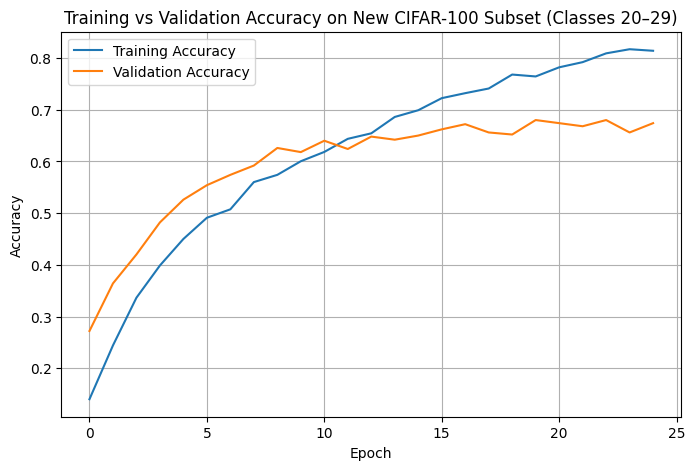

In [127]:
# Reuse the base model architecture
model_new_subset = build_base_model()

# Explicitly compile the new model instance
model_new_subset.compile(optimizer='adam',
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])


# Train on the new subset
history_new = model_new_subset.fit(
    x_train_new_final, y_train_new_final,
    epochs=25,
    batch_size=64,
    validation_data=(x_test_new_final, y_test_new_final)
)

# Evaluate
test_loss_new, test_acc_new = model_new_subset.evaluate(x_test_new_final, y_test_new_final)
print(f"Test Accuracy on New CIFAR-100 Subset (Classes 20–29): {test_acc_new * 100:.2f}%")

# Plot training and validation accuracy for the new subset
plt.figure(figsize=(8, 5))
plt.plot(history_new.history['accuracy'], label='Training Accuracy')
plt.plot(history_new.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy on New CIFAR-100 Subset (Classes 20–29)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [40]:
# Repeat TASK-5.1: Increasing size and depth of inner layers
print("\n--- TASK-5.1: Increasing Size and Depth ---")

def build_deeper_model(num_classes=10):
    model = models.Sequential([
        layers.Input(shape=(32, 32, 3)),
        # Block 1
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.2),

        # Block 2
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),

        # Block 3
        layers.Conv2D(256, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),

        # Dense
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Calling the function again for new class sets
deeper_model = build_deeper_model(num_classes=10)
print("\nDeeper Model Summary (New Subsets 20-29):")
deeper_model.summary()


--- TASK-5.1: Increasing Size and Depth ---

Deeper Model Summary (New Subsets 20-29):


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_53 (Conv2D)              │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_54 (Conv2D)              │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_53 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_55 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_56 (Conv2D)              │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_54 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_57 (Conv2D)              │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_58 (Conv2D)              │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_55 (MaxPooling2D) │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_20 (Flatten)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 64)             │       262,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,419,018 (5.41 MB)

 Trainable params: 1,418,122 (5.41 MB)

 Non-trainable params: 896 (3.50 KB)

In [41]:
#Train and Evaluate the Deeper Model for new datasets (Increasing Depth and Size)
print("\nTraining Deeper Model...")
history_deeper = deeper_model.fit(
    x_train_final, y_train_final, # Using data from the initial subset (classes 0-9)
    epochs=15,
    batch_size=64,
    validation_data=(x_test_final, y_test_final) # Using test data from the initial subset (classes 0-9)
)

test_loss_deeper, test_acc_deeper = deeper_model.evaluate(x_test_final, y_test_final, verbose=0)
print(f"\nTest Accuracy_Deeper Model(Increasing Size and Depth) for new datasets (20-29): {test_acc_deeper * 100:.2f}%")



Training Deeper Model...
Epoch 1/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 20s 204ms/step - accuracy: 0.2323 - loss: 2.3125 - val_accuracy: 0.1200 - val_loss: 2.4072
Epoch 2/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4303 - loss: 1.7369 - val_accuracy: 0.0980 - val_loss: 2.5594
Epoch 3/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5360 - loss: 1.4252 - val_accuracy: 0.1200 - val_loss: 2.5020
Epoch 4/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5902 - loss: 1.2651 - val_accuracy: 0.1040 - val_loss: 3.1295
Epoch 5/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6416 - loss: 1.1115 - val_accuracy: 0.1000 - val_loss: 3.3360
Epoch 6/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6953 - loss: 0.9403 - val_accuracy: 0.2000 - val_loss: 2.6635
Epoch 7/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7055 - loss: 0.8657 - val_accuracy: 0.1120 - val_loss: 3.6823
Epoch 8/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7557 - loss: 0.738

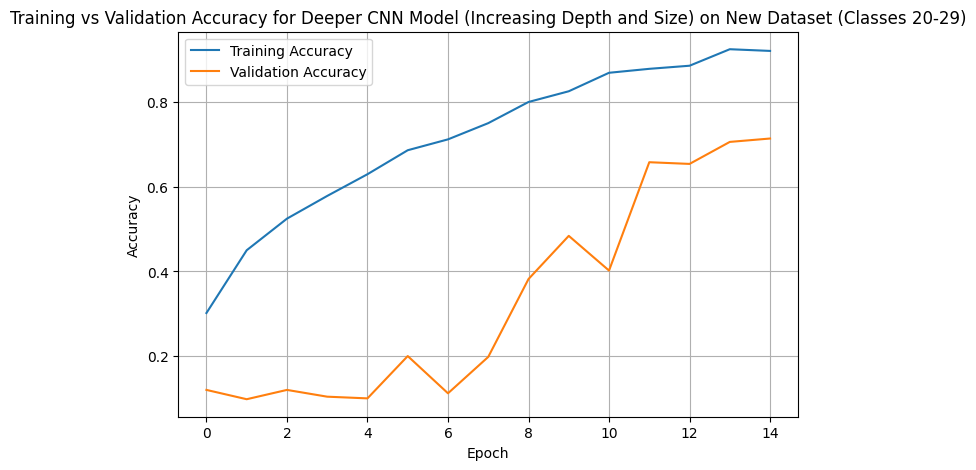

In [42]:
# Plot training and validation accuracy for the deeper model (Task 5.1 - New Dataset)
plt.figure(figsize=(8, 5))
plt.plot(history_deeper.history['accuracy'], label='Training Accuracy')
plt.plot(history_deeper.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy for Deeper CNN Model (Increasing Depth and Size) on New Dataset (Classes 20-29)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [130]:
# Repeat TASK-5.2: Convolutional/Maxpooling (More Layers)
print("\n--- TASK-5.2: More Convolutional/Maxpooling Layers ---")

# Add num_classes as a parameter to the function definition
def build_very_deep_model_v2(num_classes=10):
    model = models.Sequential([
        # Block 1
        layers.Input(shape=(32, 32, 3)),
        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        # Block 2
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        # Block 3
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),

        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Calling the function again for new class sets
very_deep_model_new = build_very_deep_model_v2()
print("\nVery Deep Model Summary (New Subset):")
very_deep_model_new.summary()


--- TASK-5.2: More Convolutional/Maxpooling Layers ---

Very Deep Model Summary (New Subset):


Model: "sequential_67"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_165 (Conv2D)             │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_159               │ (None, 16, 16, 32)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_166 (Conv2D)             │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_160               │ (None, 8, 8, 64)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_167 (Conv2D)             │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_161               │ (None, 4, 4, 128)      │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_67 (Flatten)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_187 (Dense)               │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_188 (Dense)               │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_189 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_190 (Dense)               │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 268,298 (1.02 MB)

 Trainable params: 268,298 (1.02 MB)

 Non-trainable params: 0 (0.00 B)


Training Very Deep Model on New Subset (Classes 20-29)...
Epoch 1/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.1146 - loss: 2.2819 - val_accuracy: 0.2900 - val_loss: 2.0066
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2974 - loss: 1.9330 - val_accuracy: 0.4360 - val_loss: 1.7240
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4082 - loss: 1.6764 - val_accuracy: 0.4660 - val_loss: 1.5608
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4633 - loss: 1.5200 - val_accuracy: 0.5340 - val_loss: 1.3938
Epoch 5/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5559 - loss: 1.3030 - val_accuracy: 0.5680 - val_loss: 1.3095
Epoch 6/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6256 - loss: 1.1205 - val_accuracy: 0.6160 - val_loss: 1.1731
Epoch 7/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6644 - loss: 0.9951 - val_accuracy: 0.6180 - val_loss: 1.1464
Epoch 8/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accura

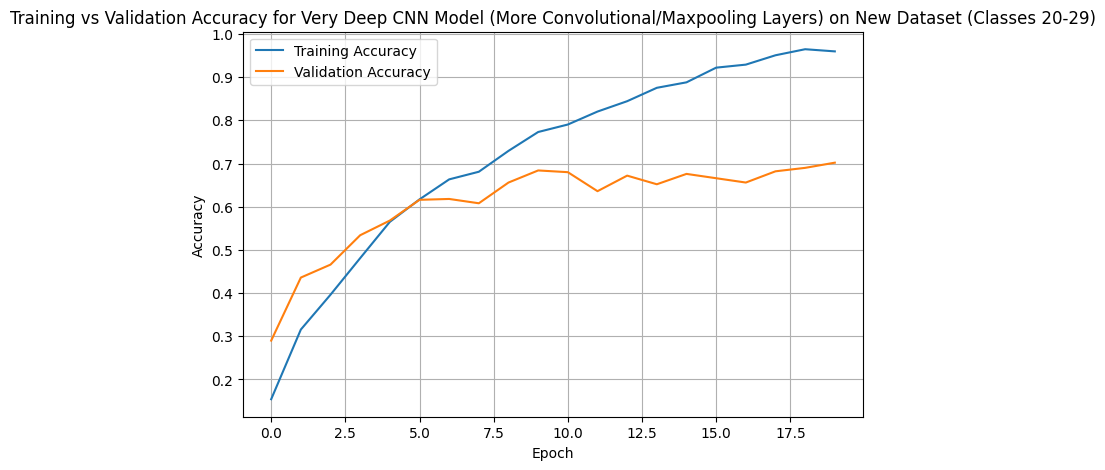


Training Very Deep Model on New Subset (Classes 20-29)...
Epoch 1/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9778 - loss: 0.0932 - val_accuracy: 0.7100 - val_loss: 1.4911
Epoch 2/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9767 - loss: 0.0780 - val_accuracy: 0.6780 - val_loss: 1.7720
Epoch 3/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9815 - loss: 0.0609 - val_accuracy: 0.6480 - val_loss: 2.0048
Epoch 4/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9742 - loss: 0.0861 - val_accuracy: 0.6740 - val_loss: 1.8271
Epoch 5/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9946 - loss: 0.0262 - val_accuracy: 0.6940 - val_loss: 1.8648
Epoch 6/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9999 - loss: 0.0068 - val_accuracy: 0.6860 - val_loss: 1.9656
Epoch 7/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0031 - val_accuracy: 0.6840 - val_loss: 2.0566
Epoch 8/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accurac

In [131]:
# Train and Evaluate the model Maxpooling/Convolutional for New Datasets
print("\nTraining Very Deep Model on New Subset (Classes 20-29)...")
# Use the data for the new subset (classes 20-29)
history_very_deep_new = very_deep_model_new.fit(
    x_train_new_final, y_train_new_final,
    epochs=20,
    batch_size=64,
    validation_data=(x_test_new_final, y_test_new_final)
)

test_loss_very_deep_new, test_acc_very_deep_new = very_deep_model_new.evaluate(x_test_new_final, y_test_new_final, verbose=0)
print(f"\nTest Accuracy_build_very_deep_model (Convolutional/Maxpooling) on New Subsets (20-29): {test_acc_very_deep_new * 100:.2f}%")
# Plot training and validation accuracy for the very deep model (Task 5.2 - New Dataset)
plt.figure(figsize=(8, 5))
plt.plot(history_very_deep_new.history['accuracy'], label='Training Accuracy')
plt.plot(history_very_deep_new.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy for Very Deep CNN Model (More Convolutional/Maxpooling Layers) on New Dataset (Classes 20-29)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()
# Train and Evaluate the model Maxpooling/Convolutional for New Datasets
print("\nTraining Very Deep Model on New Subset (Classes 20-29)...")
# Use the data for the new subset (classes 20-29)
history_very_deep_new = very_deep_model_new.fit(
    x_train_new_final, y_train_new_final,
    epochs=15,
    batch_size=64,
    validation_data=(x_test_new_final, y_test_new_final)
)


In [48]:
# --- Repeat TASK-5.3 for the New Dataset: Experiment with Activation Functions (Model Definition) ---
print("\n--- TASK-5.3 (New Dataset): Experiment with Activation Functions (Model Definition) ---")

# This function builds the model structure similar to the original TASK 5.3,
# but uses the specified activation and num_classes for the final layer.
def build_model_with_activation_new_data(activation='relu', use_leaky=False, num_classes=10):
    model = models.Sequential()
    model.add(layers.Input(shape=(32, 32, 3)))

    # Convolutional Layer 1
    model.add(layers.Conv2D(32, (3, 3), padding='same'))
    if use_leaky:
        model.add(LeakyReLU(alpha=0.1))
    else:
        model.add(layers.Activation(activation))
    model.add(layers.MaxPooling2D((2, 2)))

    # Convolutional Layer 2
    model.add(layers.Conv2D(64, (3, 3), padding='same'))
    if use_leaky:
        model.add(LeakyReLU(alpha=0.1))
    else:
    # Check if the activation is a callable function like swish
        if callable(activation):
            model.add(layers.Activation(activation))
        else:
            model.add(layers.Activation(activation))

    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())

    # Dense Layer
    model.add(layers.Dense(64))
    if use_leaky:
        model.add(LeakyReLU(alpha=0.1))
    else:
        if callable(activation):
            model.add(layers.Activation(activation))
        else:
            model.add(layers.Activation(activation))

    # Output Layer
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# New subset (20-29)
num_classes_new_subset = 10

# Building each model summary
print("\nBuilding Relu model...")
model_relu_new = build_model_with_activation_new_data('relu', num_classes=num_classes_new_subset)
model_relu_new.summary()

print("\nBuilding Sigmoid model...")
model_sigmoid_new = build_model_with_activation_new_data('sigmoid', num_classes=num_classes_new_subset)
model_sigmoid_new.summary()

print("\nBuilding Swish model...")
model_swish_new = build_model_with_activation_new_data(swish, num_classes=num_classes_new_subset)
model_swish_new.summary()

print("\nBuilding Tanh model...")
model_tanh_new = build_model_with_activation_new_data('tanh', num_classes=num_classes_new_subset)
model_tanh_new.summary()

print("\nBuilding Leaky ReLU model...")
model_leaky_new = build_model_with_activation_new_data(activation=None, use_leaky=True, num_classes=num_classes_new_subset)
model_leaky_new.summary()


--- TASK-5.3 (New Dataset): Experiment with Activation Functions (Model Definition) ---

Building Relu model...


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_65 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_62 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_66 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_63 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_23 (Flatten)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 64)             │       262,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 282,250 (1.08 MB)

 Trainable params: 282,250 (1.08 MB)

 Non-trainable params: 0 (0.00 B)


Building Sigmoid model...


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_67 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_64 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_68 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_65 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_24 (Flatten)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 64)             │       262,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 282,250 (1.08 MB)

 Trainable params: 282,250 (1.08 MB)

 Non-trainable params: 0 (0.00 B)


Building Swish model...


Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_69 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_15 (Activation)      │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_66 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_70 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_16 (Activation)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_67 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_25 (Flatten)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 64)             │       262,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_17 (Activation)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 282,250 (1.08 MB)

 Trainable params: 282,250 (1.08 MB)

 Non-trainable params: 0 (0.00 B)


Building Tanh model...


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_71 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_18 (Activation)      │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_68 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_72 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_19 (Activation)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_69 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_26 (Flatten)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 64)             │       262,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_20 (Activation)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 282,250 (1.08 MB)

 Trainable params: 282,250 (1.08 MB)

 Non-trainable params: 0 (0.00 B)


Building Leaky ReLU model...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_73 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_70 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_74 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_71 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_27 (Flatten)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 64)             │       262,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 282,250 (1.08 MB)

 Trainable params: 282,250 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

In [49]:
# --- Repeat TASK-5.3 for the New Dataset: Experiment with Activation Functions (Training) ---
print("\n--- TASK-5.3 (New Dataset): Experiment with Activation Functions (Training) ---")

epochs = 20
batch_size = 64

# Training Relu model on New Subset
print("\nTraining Relu model on New Subset...")
history_relu_new = model_relu_new.fit(
    x_train_new_final, y_train_new_final, # Use the new subset data
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_test_new_final, y_test_new_final), # Use the new subset test data
    verbose=2 # Use verbose=2 to show epoch progress
)

# Training Sigmoid model on New Subset
print("\nTraining Sigmoid model on New Subset...")
history_sigmoid_new = model_sigmoid_new.fit(
    x_train_new_final, y_train_new_final,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_test_new_final, y_test_new_final),
    verbose=2
)

# Training Swish model on New Subset
print("\nTraining Swish model on New Subset...")
history_swish_new = model_swish_new.fit(
    x_train_new_final, y_train_new_final,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_test_new_final, y_test_new_final),
    verbose=2
)

# Training Tanh model on New Subset
print("\nTraining Tanh model on New Subset...")
history_tanh_new = model_tanh_new.fit(
    x_train_new_final, y_train_new_final,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_test_new_final, y_test_new_final),
    verbose=2
)

# Training Leaky ReLU model on New Subset
print("\nTraining Leaky ReLU model on New Subset...")
history_leaky_new = model_leaky_new.fit(
    x_train_new_final, y_train_new_final,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_test_new_final, y_test_new_final),
    verbose=2
)


--- TASK-5.3 (New Dataset): Experiment with Activation Functions (Training) ---

Training Relu model on New Subset...
Epoch 1/20
47/47 - 4s - 81ms/step - accuracy: 0.2037 - loss: 2.1621 - val_accuracy: 0.3440 - val_loss: 1.8597
Epoch 2/20
47/47 - 3s - 57ms/step - accuracy: 0.4217 - loss: 1.7026 - val_accuracy: 0.4940 - val_loss: 1.5356
Epoch 3/20
47/47 - 0s - 6ms/step - accuracy: 0.5410 - loss: 1.3981 - val_accuracy: 0.5580 - val_loss: 1.3783
Epoch 4/20
47/47 - 0s - 6ms/step - accuracy: 0.6003 - loss: 1.2175 - val_accuracy: 0.5960 - val_loss: 1.2599
Epoch 5/20
47/47 - 0s - 6ms/step - accuracy: 0.6537 - loss: 1.0729 - val_accuracy: 0.6040 - val_loss: 1.2553
Epoch 6/20
47/47 - 0s - 7ms/step - accuracy: 0.6793 - loss: 0.9799 - val_accuracy: 0.6000 - val_loss: 1.2649
Epoch 7/20
47/47 - 0s - 6ms/step - accuracy: 0.7130 - loss: 0.8743 - val_accuracy: 0.6120 - val_loss: 1.2397
Epoch 8/20
47/47 - 0s - 6ms/step - accuracy: 0.7323 - loss: 0.8334 - val_accuracy: 0.6160 - val_loss: 1.2429
Epoch 9


Evaluating models on New Subset (Classes 20-29)...
ReLU Test Accuracy (New Subset): 0.6380
Sigmoid Test Accuracy (New Subset): 0.4400
Leaky ReLU Test Accuracy (New Subset): 0.6720
Tanh Test Accuracy (New Subset): 0.6700
Swish Test Accuracy (New Subset): 0.6380


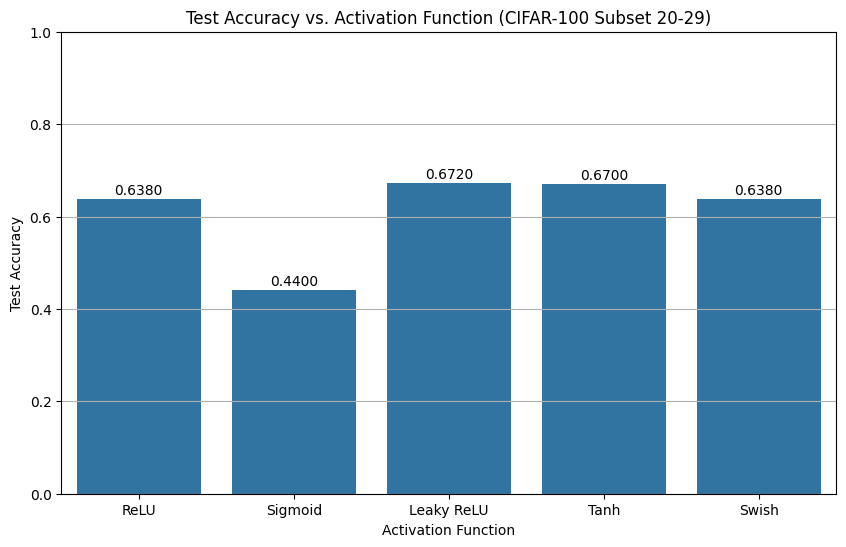

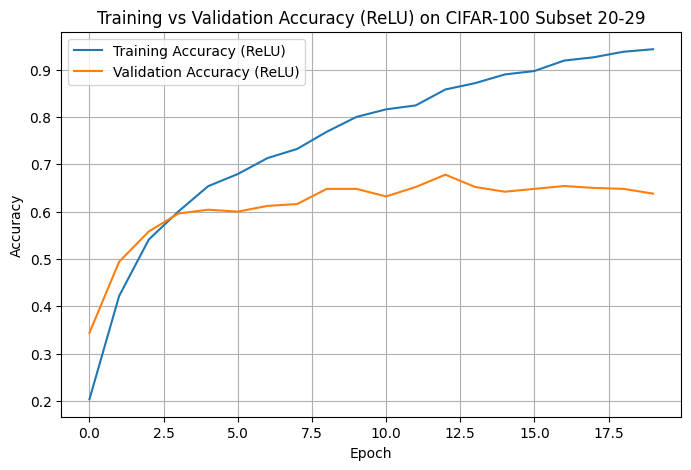

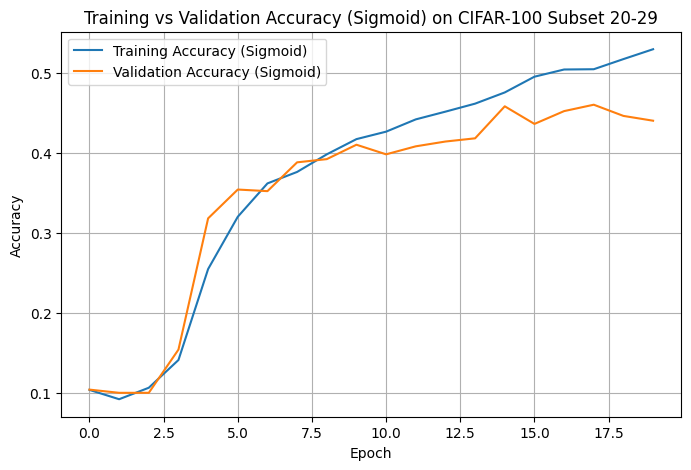

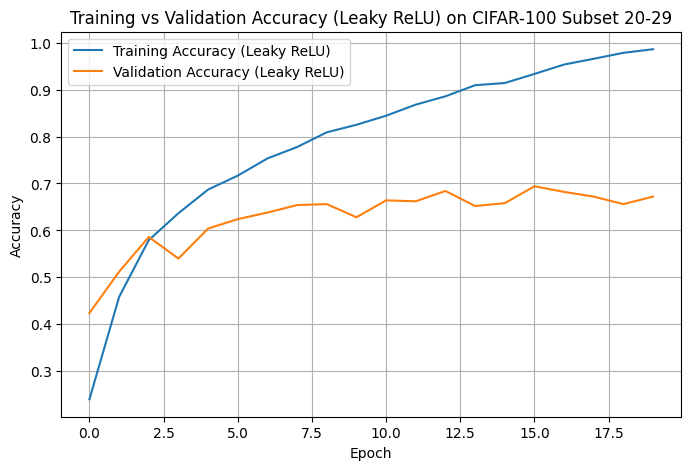

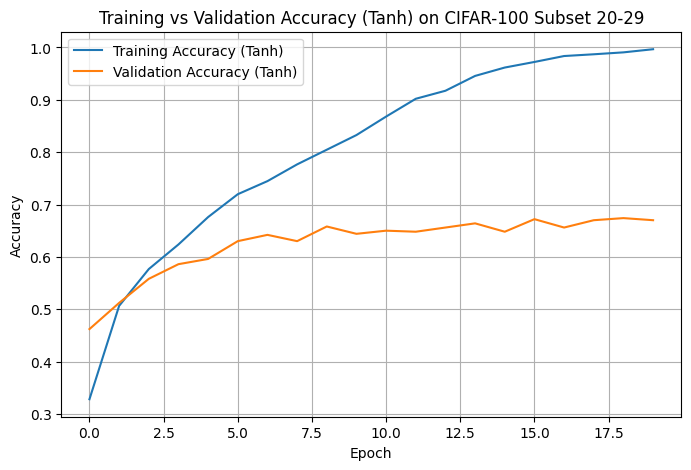

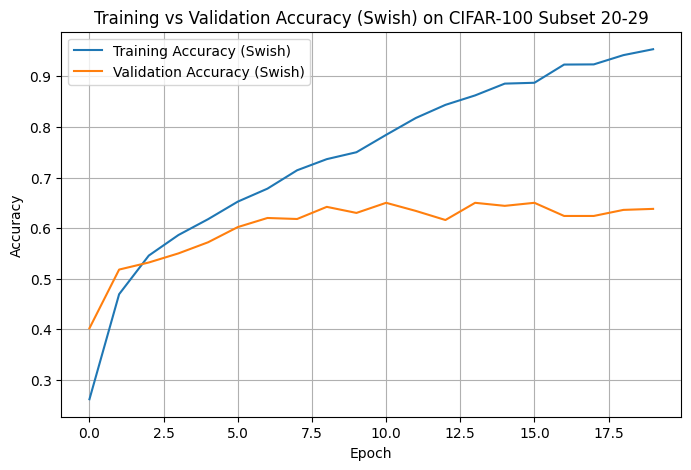

In [50]:
# --- TASK-5.3: Experiment with Activation Functions (Evaluation and Plotting - New Subset 20-29)
print("\nEvaluating models on New Subset (Classes 20-29)...")

# Use the model variables trained on the new dataset and the new test data
test_loss_relu_new, test_acc_relu_new = model_relu_new.evaluate(x_test_new_final, y_test_new_final, verbose=0)
print(f"ReLU Test Accuracy (New Subset): {test_acc_relu_new:.4f}")

test_loss_sigmoid_new, test_acc_sigmoid_new = model_sigmoid_new.evaluate(x_test_new_final, y_test_new_final, verbose=0)
print(f"Sigmoid Test Accuracy (New Subset): {test_acc_sigmoid_new:.4f}")

# Note: You defined `model_leaky_new` for Leaky ReLU for the new dataset
test_loss_leaky_new, test_acc_leaky_new = model_leaky_new.evaluate(x_test_new_final, y_test_new_final, verbose=0)
print(f"Leaky ReLU Test Accuracy (New Subset): {test_acc_leaky_new:.4f}")

test_loss_tanh_new, test_acc_tanh_new = model_tanh_new.evaluate(x_test_new_final, y_test_new_final, verbose=0)
print(f"Tanh Test Accuracy (New Subset): {test_acc_tanh_new:.4f}")

# Note: You defined `model_swish_new` for Swish for the new dataset
test_loss_swish_new, test_acc_swish_new = model_swish_new.evaluate(x_test_new_final, y_test_new_final, verbose=0)
print(f"Swish Test Accuracy (New Subset): {test_acc_swish_new:.4f}")


# Store the test accuracies for the new subset
# Ensure the order matches the plot labels
activations_new_subset = ['ReLU', 'Sigmoid', 'Leaky ReLU', 'Tanh', 'Swish']
accuracies_new_subset = [
    test_acc_relu_new,
    test_acc_sigmoid_new,
    test_acc_leaky_new, # Use the accuracy for the Leaky ReLU model trained on the new data
    test_acc_tanh_new,
    test_acc_swish_new # Use the accuracy for the Swish model trained on the new data
]

plt.figure(figsize=(10, 6))
sns.barplot(x=activations_new_subset, y=accuracies_new_subset)
plt.title('Test Accuracy vs. Activation Function (CIFAR-100 Subset 20-29)')
plt.xlabel('Activation Function')
plt.ylabel('Test Accuracy')
plt.ylim(0, 1) # Accuracy is between 0 and 1
plt.grid(axis='y')

# Add accuracy values on top of bars
for i, acc in enumerate(accuracies_new_subset):
    plt.text(i, acc + 0.01, f'{acc:.4f}', ha='center')

plt.show()

# --- Plotting Accuracy for Each Activation Function (20-29 Subset) ---

# Plot for ReLU (New Subset)
plt.figure(figsize=(8, 5))
plt.plot(history_relu_new.history['accuracy'], label='Training Accuracy (ReLU)')
plt.plot(history_relu_new.history['val_accuracy'], label='Validation Accuracy (ReLU)')
plt.title('Training vs Validation Accuracy (ReLU) on CIFAR-100 Subset 20-29')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot for Sigmoid (New Subset)
plt.figure(figsize=(8, 5))
plt.plot(history_sigmoid_new.history['accuracy'], label='Training Accuracy (Sigmoid)')
plt.plot(history_sigmoid_new.history['val_accuracy'], label='Validation Accuracy (Sigmoid)')
plt.title('Training vs Validation Accuracy (Sigmoid) on CIFAR-100 Subset 20-29')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot for Leaky ReLU (New Subset)
plt.figure(figsize=(8, 5))
plt.plot(history_leaky_new.history['accuracy'], label='Training Accuracy (Leaky ReLU)')
plt.plot(history_leaky_new.history['val_accuracy'], label='Validation Accuracy (Leaky ReLU)')
plt.title('Training vs Validation Accuracy (Leaky ReLU) on CIFAR-100 Subset 20-29')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


# Plot for Tanh (New Subset)
plt.figure(figsize=(8, 5))
plt.plot(history_tanh_new.history['accuracy'], label='Training Accuracy (Tanh)')
plt.plot(history_tanh_new.history['val_accuracy'], label='Validation Accuracy (Tanh)')
plt.title('Training vs Validation Accuracy (Tanh) on CIFAR-100 Subset 20-29')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot for Swish (New Subset)
plt.figure(figsize=(8, 5))
plt.plot(history_swish_new.history['accuracy'], label='Training Accuracy (Swish)')
plt.plot(history_swish_new.history['val_accuracy'], label='Validation Accuracy (Swish)')
plt.title('Training vs Validation Accuracy (Swish) on CIFAR-100 Subset 20-29')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [51]:
# --- Repeat TASK-5.5: Experiment with Optimizers and Learning Rates ---
print("\n--- TASK-5.5: Experiment with Optimizers and Learning Rates ---")

# Use a base model structure for consistent comparison
def build_simple_model():
    model = models.Sequential([
        layers.Input(shape=(32, 32, 3)),
        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),


        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(len(selected_classes), activation='softmax')
    ])
    return model

# Build an instance of the simple model to display its summary for the Optimizer Experiment
simple_model_for_optimizer_summary = build_simple_model()
print("\nSimple Model Summary for Optimizer Experiment:")
simple_model_for_optimizer_summary.summary()



--- TASK-5.5: Experiment with Optimizers and Learning Rates ---

Simple Model Summary for Optimizer Experiment:


Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_75 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_72 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_76 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_73 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_77 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_74 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_28 (Flatten)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 233,994 (914.04 KB)

 Trainable params: 233,994 (914.04 KB)

 Non-trainable params: 0 (0.00 B)

In [52]:
# Define the number of epochs and batch size for training
epochs = 20 # You can adjust this
batch_size = 64 # You can adjust this

# --- Experiment with different optimizers and learning rates ---

# Example 1: Adam with learning rate 0.001
model_adam = build_simple_model() # Build a new instance for each experiment
opt_adam = Adam(learning_rate=0.001)
model_adam.compile(optimizer=opt_adam, loss='categorical_crossentropy', metrics=['accuracy'])
print("\nTraining with Adam (lr=0.001)...")
history_adam = model_adam.fit(
    x_train_new_final, y_train_new_final, # Use the new subset data
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_test_new_final, y_test_new_final), # Use the new subset test data
    verbose=2 # Use verbose=2 to show epoch progress
)
test_loss_adam, test_acc_adam = model_adam.evaluate(x_test_new_final, y_test_new_final, verbose=0)
print(f"Test Accuracy (Adam, lr=0.001): {test_acc_adam * 100:.2f}%")

# Example 2: SGD with learning rate 0.01 and momentum 0.9
model_sgd = build_simple_model()
opt_sgd = SGD(learning_rate=0.01, momentum=0.9)
model_sgd.compile(optimizer=opt_sgd, loss='categorical_crossentropy', metrics=['accuracy'])
print("\nTraining with SGD (lr=0.01, momentum=0.9)...")
history_sgd = model_sgd.fit(
    x_train_new_final, y_train_new_final,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_test_new_final, y_test_new_final),
    verbose=2
)
test_loss_sgd, test_acc_sgd = model_sgd.evaluate(x_test_new_final, y_test_new_final, verbose=0)
print(f"Test Accuracy (SGD, lr=0.01, momentum=0.9): {test_acc_sgd * 100:.2f}%")

# Example 3: RMSprop with learning rate 0.0001
model_rmsprop = build_simple_model()
opt_rmsprop = RMSprop(learning_rate=0.0001)
model_rmsprop.compile(optimizer=opt_rmsprop, loss='categorical_crossentropy', metrics=['accuracy'])
print("\nTraining with RMSprop (lr=0.0001)...")
history_rmsprop = model_rmsprop.fit(
    x_train_new_final, y_train_new_final,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_test_new_final, y_test_new_final),
    verbose=2
)
test_loss_rmsprop, test_acc_rmsprop = model_rmsprop.evaluate(x_test_new_final, y_test_new_final, verbose=0)
print(f"Test Accuracy (RMSprop, lr=0.0001): {test_acc_rmsprop * 100:.2f}%")


Training with Adam (lr=0.001)...
Epoch 1/20
47/47 - 5s - 97ms/step - accuracy: 0.1780 - loss: 2.2073 - val_accuracy: 0.2260 - val_loss: 1.9943
Epoch 2/20
47/47 - 3s - 56ms/step - accuracy: 0.3727 - loss: 1.7957 - val_accuracy: 0.4520 - val_loss: 1.6789
Epoch 3/20
47/47 - 0s - 6ms/step - accuracy: 0.4880 - loss: 1.5132 - val_accuracy: 0.5300 - val_loss: 1.4229
Epoch 4/20
47/47 - 0s - 6ms/step - accuracy: 0.5357 - loss: 1.3495 - val_accuracy: 0.5120 - val_loss: 1.4226
Epoch 5/20
47/47 - 0s - 6ms/step - accuracy: 0.6063 - loss: 1.1880 - val_accuracy: 0.5520 - val_loss: 1.3412
Epoch 6/20
47/47 - 0s - 6ms/step - accuracy: 0.6307 - loss: 1.1005 - val_accuracy: 0.5980 - val_loss: 1.2312
Epoch 7/20
47/47 - 0s - 6ms/step - accuracy: 0.6723 - loss: 0.9870 - val_accuracy: 0.6180 - val_loss: 1.1477
Epoch 8/20
47/47 - 0s - 6ms/step - accuracy: 0.7050 - loss: 0.9093 - val_accuracy: 0.6240 - val_loss: 1.1283
Epoch 9/20
47/47 - 0s - 6ms/step - accuracy: 0.7347 - loss: 0.7920 - val_accuracy: 0.6500 - 

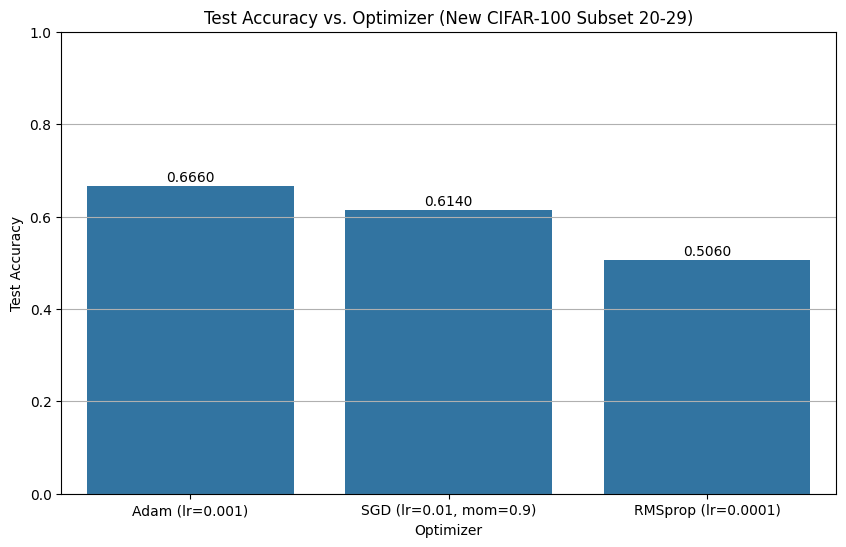

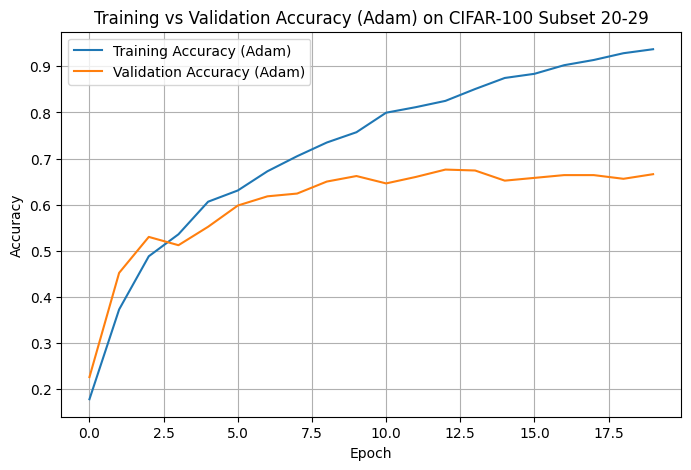

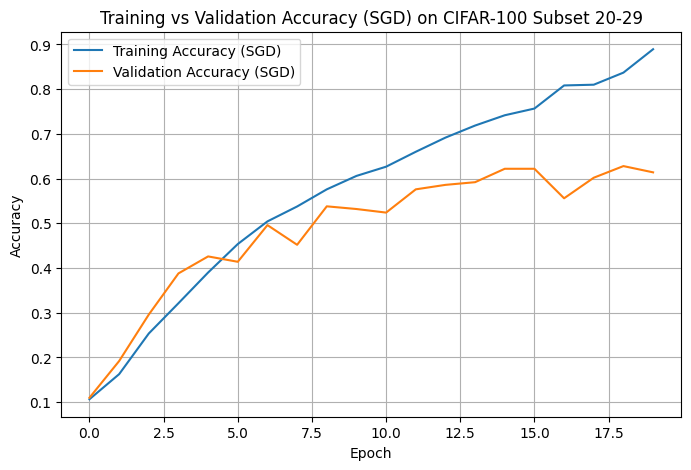

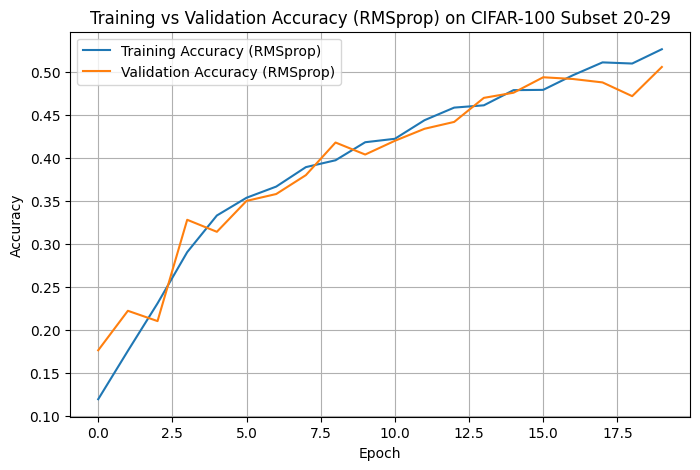

In [53]:
# --- Plotting the results ---

# Store the optimizer names and their accuracies
optimizers = ['Adam (lr=0.001)', 'SGD (lr=0.01, mom=0.9)', 'RMSprop (lr=0.0001)']
accuracies = [test_acc_adam, test_acc_sgd, test_acc_rmsprop]

plt.figure(figsize=(10, 6))
sns.barplot(x=optimizers, y=accuracies)
plt.title('Test Accuracy vs. Optimizer (New CIFAR-100 Subset 20-29)')
plt.xlabel('Optimizer')
plt.ylabel('Test Accuracy')
plt.ylim(0, 1) # Accuracy is between 0 and 1
plt.grid(axis='y')

# Add accuracy values on top of bars
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f'{acc:.4f}', ha='center')

plt.show()


# --- Plotting Training/Validation Accuracy Curves for each optimizer (New Subset) ---

# Plot for Adam (New Subset)
plt.figure(figsize=(8, 5))
plt.plot(history_adam.history['accuracy'], label='Training Accuracy (Adam)')
plt.plot(history_adam.history['val_accuracy'], label='Validation Accuracy (Adam)')
plt.title('Training vs Validation Accuracy (Adam) on CIFAR-100 Subset 20-29')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot for SGD (New Subset)
plt.figure(figsize=(8, 5))
plt.plot(history_sgd.history['accuracy'], label='Training Accuracy (SGD)')
plt.plot(history_sgd.history['val_accuracy'], label='Validation Accuracy (SGD)')
plt.title('Training vs Validation Accuracy (SGD) on CIFAR-100 Subset 20-29')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot for RMSprop (New Subset)
plt.figure(figsize=(8, 5))
plt.plot(history_rmsprop.history['accuracy'], label='Training Accuracy (RMSprop)')
plt.plot(history_rmsprop.history['val_accuracy'], label='Validation Accuracy (RMSprop)')
plt.title('Training vs Validation Accuracy (RMSprop) on CIFAR-100 Subset 20-29')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [54]:
# --- Repeat TASK-5.6: Experiment with Various Batch Sizes and Epochs -- for new CIFAR-100 subsets 20-29 ---
print("\n--- TASK-5.6 (New Dataset): Experiment with Various Batch Sizes and Epochs ---")

# Use the same simple model structure for consistent comparison
def build_simple_model(num_classes=10):
    model = models.Sequential([
        layers.Input(shape=(32, 32, 3)),
        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Build an instance of the simple model to display its summary for the Batch Size/Epochs Experiment
simple_model_for_bse_summary = build_simple_model(num_classes=10)
print("\nSimple Model Summary for Batch Size and Epochs Experiment (New Subset):")
simple_model_for_bse_summary.summary()


--- TASK-5.6 (New Dataset): Experiment with Various Batch Sizes and Epochs ---

Simple Model Summary for Batch Size and Epochs Experiment (New Subset):


Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_87 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_84 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_88 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_85 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_89 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_86 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_32 (Flatten)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 356,810 (1.36 MB)

 Trainable params: 356,810 (1.36 MB)

 Non-trainable params: 0 (0.00 B)


Training with Batch Size 32, Epochs 10...
Epoch 1/10
94/94 - 6s - 59ms/step - accuracy: 0.2293 - loss: 2.1154 - val_accuracy: 0.3500 - val_loss: 1.8424
Epoch 2/10
94/94 - 2s - 20ms/step - accuracy: 0.4460 - loss: 1.6324 - val_accuracy: 0.4700 - val_loss: 1.5392
Epoch 3/10
94/94 - 0s - 5ms/step - accuracy: 0.5513 - loss: 1.3308 - val_accuracy: 0.5180 - val_loss: 1.4189
Epoch 4/10
94/94 - 1s - 6ms/step - accuracy: 0.6253 - loss: 1.1203 - val_accuracy: 0.5820 - val_loss: 1.2703
Epoch 5/10
94/94 - 1s - 7ms/step - accuracy: 0.6853 - loss: 0.9380 - val_accuracy: 0.6380 - val_loss: 1.1167
Epoch 6/10
94/94 - 1s - 6ms/step - accuracy: 0.7387 - loss: 0.8063 - val_accuracy: 0.6280 - val_loss: 1.1166
Epoch 7/10
94/94 - 0s - 5ms/step - accuracy: 0.7723 - loss: 0.6984 - val_accuracy: 0.6080 - val_loss: 1.1611
Epoch 8/10
94/94 - 1s - 6ms/step - accuracy: 0.8003 - loss: 0.5959 - val_accuracy: 0.6680 - val_loss: 0.9955
Epoch 9/10
94/94 - 0s - 4ms/step - accuracy: 0.8420 - loss: 0.4920 - val_accuracy: 

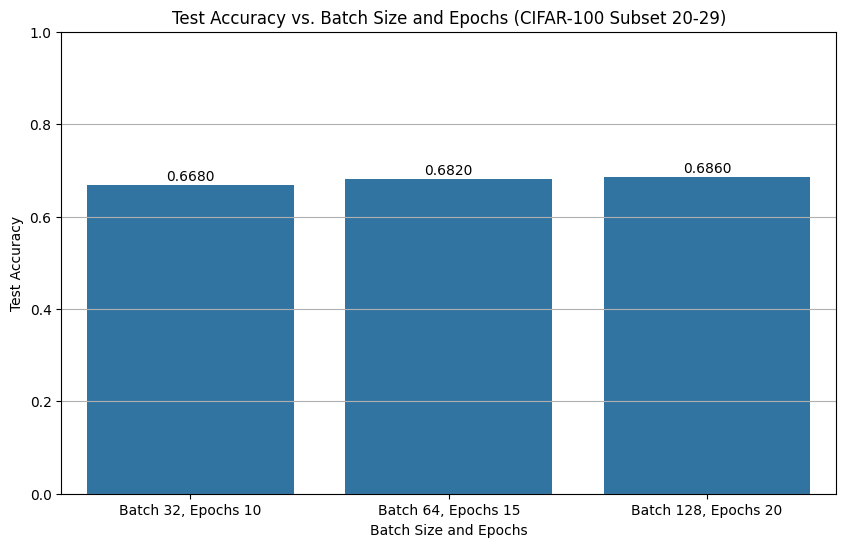

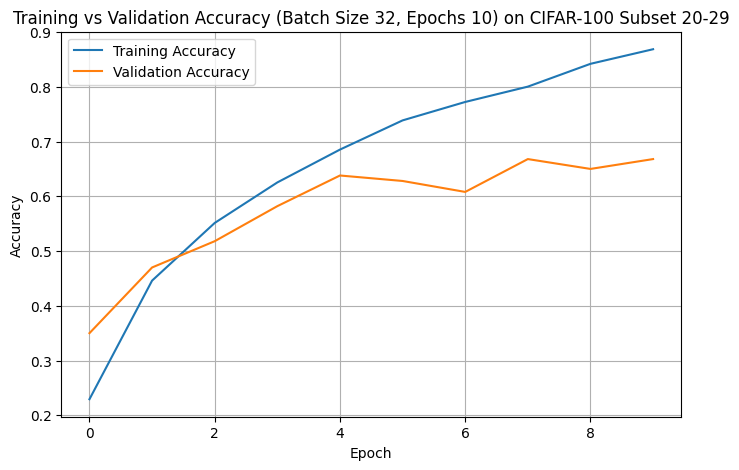

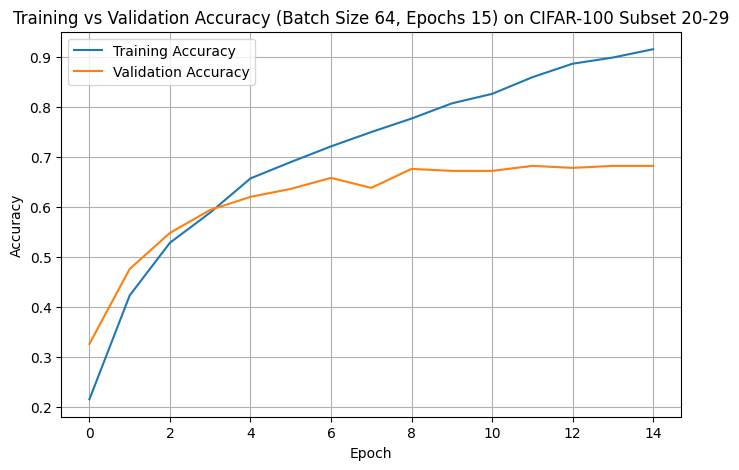

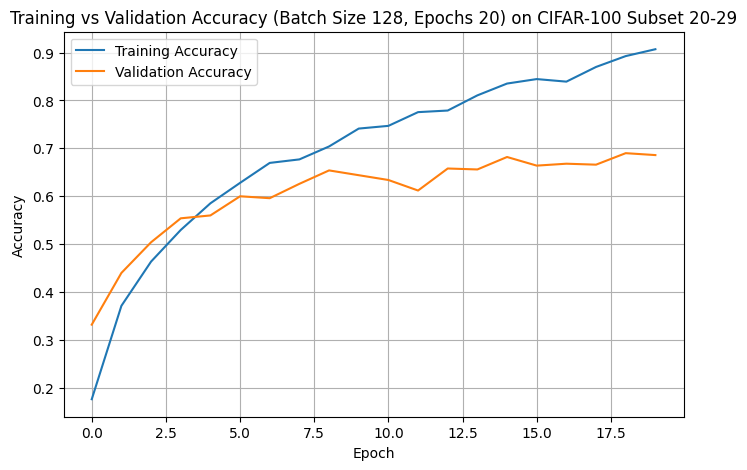

In [55]:
# Defining the data for the new subset (classes 20-29)
# x_train_new_final, y_train_new_final, x_test_new_final, y_test_new_final

# Example 1: Batch size 32, Epochs 10
print("\nTraining with Batch Size 32, Epochs 10...")
model_b32_e10_new = build_simple_model(num_classes=10)
model_b32_e10_new.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_b32_e10_new = model_b32_e10_new.fit(x_train_new_final, y_train_new_final, epochs=10, batch_size=32,
                                          validation_data=(x_test_new_final, y_test_new_final), verbose=2)

# Example 2: Batch size 64, Epochs 15
print("\nTraining with Batch Size 64, Epochs 15...")
model_b64_e15_new = build_simple_model(num_classes=10)
model_b64_e15_new.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_b64_e15_new = model_b64_e15_new.fit(x_train_new_final, y_train_new_final, epochs=15, batch_size=64,
                                          validation_data=(x_test_new_final, y_test_new_final), verbose=2)

# Example 3: Batch size 128, Epochs 20
print("\nTraining with Batch Size 128, Epochs 20...")
model_b128_e20_new = build_simple_model(num_classes=10)
model_b128_e20_new.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history_b128_e20_new = model_b128_e20_new.fit(x_train_new_final, y_train_new_final, epochs=20, batch_size=128,
                                           validation_data=(x_test_new_final, y_test_new_final), verbose=2)

# Evaluation and Plotting for the New Dataset
print("\nEvaluating models on New Subset (Classes 20-29)...")

acc_b32_e10_new = history_b32_e10_new.history['val_accuracy'][-1]
acc_b64_e15_new = history_b64_e15_new.history['val_accuracy'][-1]
acc_b128_e20_new = history_b128_e20_new.history['val_accuracy'][-1]

print(f"New Subset: Batch 32, Epoch 10 - Val Accuracy: {acc_b32_e10_new:.4f}")
print(f"New Subset: Batch 64, Epoch 15 - Val Accuracy: {acc_b64_e15_new:.4f}")
print(f"New Subset: Batch 128, Epoch 20 - Val Accuracy: {acc_b128_e20_new:.4f}")

# Store the combinations and their accuracies for the new dataset
combinations_new = ['Batch 32, Epochs 10', 'Batch 64, Epochs 15', 'Batch 128, Epochs 20']
accuracies_new = [acc_b32_e10_new, acc_b64_e15_new, acc_b128_e20_new]

plt.figure(figsize=(10, 6))
sns.barplot(x=combinations_new, y=accuracies_new)
plt.title('Test Accuracy vs. Batch Size and Epochs (CIFAR-100 Subset 20-29)')
plt.xlabel('Batch Size and Epochs')
plt.ylabel('Test Accuracy')
plt.ylim(0, 1) # Accuracy is between 0 and 1
plt.grid(axis='y')

# Add accuracy values on top of bars
for i, acc in enumerate(accuracies_new):
    plt.text(i, acc + 0.01, f'{acc:.4f}', ha='center')

plt.show()

# --- Plotting Training/Validation Accuracy Curves for each combination (New Subset) ---

# Plot for Batch Size 32, Epochs 10 (New Subset)
plt.figure(figsize=(8, 5))
plt.plot(history_b32_e10_new.history['accuracy'], label='Training Accuracy')
plt.plot(history_b32_e10_new.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy (Batch Size 32, Epochs 10) on CIFAR-100 Subset 20-29')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot for Batch Size 64, Epochs 15 (New Subset)
plt.figure(figsize=(8, 5))
plt.plot(history_b64_e15_new.history['accuracy'], label='Training Accuracy')
plt.plot(history_b64_e15_new.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy (Batch Size 64, Epochs 15) on CIFAR-100 Subset 20-29')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot for Batch Size 128, Epochs 20 (New Subset)
plt.figure(figsize=(8, 5))
plt.plot(history_b128_e20_new.history['accuracy'], label='Training Accuracy')
plt.plot(history_b128_e20_new.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy (Batch Size 128, Epochs 20) on CIFAR-100 Subset 20-29')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

### Evaluate the model

Experiments on CIFAR-100 subsets (classes 0–9 and 20–29) confirmed consistent trends in CNN performance. Accuracy increased with model depth and layer count to a point, whereas models, which were too deep, were prone to overfitting. Tanh and Leaky ReLU activation functions fared the best, with the Sigmoid function performing the worst. Adam was found to be the most stable and accurate optimizer. The larger the batch size (128) and the longer the training (20–30 epochs), the better the performance. The initial findings were confirmed when the experiments were repeated on another subset, confirming the robustness of the experimental protocol.

Your simple CNN has achieved a test accuracy of over 70%. Not bad for a few lines of code! For another CNN style, check out the [TensorFlow 2 quickstart for experts](https://www.tensorflow.org/tutorials/quickstart/advanced) example that uses the Keras subclassing API and `tf.GradientTape`.